## About the dataset : Sample Dataset taken from Centre for Monitoring Indian Economy (CMIE) 
https://consumerpyramidsdx.cmie.com/kommon/bin/sr.php?kall=wdpi&rrurl=consumptionpyramidsdx

### Importing essential libraries

In [67]:
import numpy as np
import pandas as pd
import datetime
import matplotlib
import matplotlib.pyplot as plt
from matplotlib import colors
import seaborn as sns

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

from yellowbrick.cluster import KElbowVisualizer
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt, numpy as np

from sklearn import metrics
import warnings

import itertools

np.random.seed(42)
pd.set_option('display.max_columns', None)

#### Loading the datasets and the concatinating it into one dataset

In [2]:
file_paths = ["jan 2022.csv", "feb 2022.csv", "march 22.csv", "april 22.csv","may 22.csv","june22.csv"
              ,"july 22.csv","aug 22.csv","sep22.csv","oct 22.csv","nov22.csv","dec 22.csv","jan 23.csv"
              ,"feb 23.csv","march23.csv","april 23.csv","may 23.csv","june 23.csv","july 23.csv","aug 23.csv"
              ,"sept 23.csv","oct 23.csv","nov 23.csv","dec 23.csv"]

# List to store the loaded dataframes
dfs = []

# Iterate through each file path
for file_path in file_paths:
    # Read the dataset into a pandas DataFrame
    df = pd.read_csv(file_path)
    # Append the DataFrame to the list
    dfs.append(df)

# Concatenate the DataFrames along rows (axis=0)
data = pd.concat(dfs, axis=0, ignore_index=True)

# Save the concatenated DataFrame to a new CSV file
data.to_csv("concatenated_dataset.csv", index=False)

In [3]:
data.head()

,HH_ID,STATE,HR,REGION_TYPE,MONTH_SLOT,MONTH,REASON_FOR_NON_RESPONSE,DISTRICT,RESPONSE_STATUS,FAMILY_SHIFTED,...,MONTHLY_EXPENSE_ON_RELIGIOUS_OBLIGATIONS,MONTHLY_EXPENSE_ON_PROFESSIONAL_CONSULTATION,MONTHLY_EXPENSE_ON_GENERAL_INSURANCE,MONTHLY_EXPENSE_ON_VACATION,MONTHLY_EXPENSE_ON_LIGHTING,MONTHLY_EXPENSE_ON_FURNITURE_AND_FURNISHINGS,MONTHLY_EXPENSE_ON_PAINTING_AND_RENOVATION,MONTHLY_EXPENSE_ON_UTENSILS,MONTHLY_EXPENSE_ON_POCKET_MONEY,MONTHLY_EXPENSE_ON_PETS
0,33785184,Maharashtra,HR 42,URBAN,Apr 2020,Dec 2019,Could not be executed,Nashik,Non-Response,Data Not Available,...,-99,-99,-99,-99,-99,-99,-99,-99,-99,-99
1,23694649,Punjab,HR 5,URBAN,Apr 2020,Dec 2019,Household not found,Jalandhar,Non-Response,Data Not Available,...,-99,-99,-99,-99,-99,-99,-99,-99,-99,-99
2,76402568,Andhra Pradesh,HR 63,URBAN,Feb 2020,Dec 2019,Locked,Visakhapatnam,Non-Response,Data Not Available,...,-99,-99,-99,-99,-99,-99,-99,-99,-99,-99
3,78340278,Bihar,HR 90,URBAN,Jan 2020,Dec 2019,No Failure,Saharsa,Accepted,N,...,0,0,0,0,90,0,0,0,0,0
4,66486982,Maharashtra,HR 44,URBAN,Apr 2020,Dec 2019,No Failure,Nagpur,Accepted,N,...,0,0,0,0,0,0,0,0,1000,0


In [4]:
#looking at the distinct categories in this column for further analysis
data['REASON_FOR_NON_RESPONSE'].value_counts()

REASON_FOR_NON_RESPONSE
No Failure               1488
Could not be executed     480
Household not found       264
Locked                    144
Refused                    24
Name: count, dtype: int64

In [5]:
# i will drop all the other reasons except for No failure

condition1 = data['REASON_FOR_NON_RESPONSE'] == 'Could not be executed'
condition2 = data['REASON_FOR_NON_RESPONSE'] == 'Household not found'
condition3 = data['REASON_FOR_NON_RESPONSE'] == 'Locked'
condition4 = data['REASON_FOR_NON_RESPONSE'] == 'Refused'

# Combine the conditions using logical OR (|)
to_delete = condition1 | condition2 | condition3 | condition4

# Filter the DataFrame to keep only the rows where to_delete is False
filtered_data = data[~to_delete]
filtered_data.reset_index(drop=True, inplace=True)

In [6]:
filtered_data.head()

,HH_ID,STATE,HR,REGION_TYPE,MONTH_SLOT,MONTH,REASON_FOR_NON_RESPONSE,DISTRICT,RESPONSE_STATUS,FAMILY_SHIFTED,...,MONTHLY_EXPENSE_ON_RELIGIOUS_OBLIGATIONS,MONTHLY_EXPENSE_ON_PROFESSIONAL_CONSULTATION,MONTHLY_EXPENSE_ON_GENERAL_INSURANCE,MONTHLY_EXPENSE_ON_VACATION,MONTHLY_EXPENSE_ON_LIGHTING,MONTHLY_EXPENSE_ON_FURNITURE_AND_FURNISHINGS,MONTHLY_EXPENSE_ON_PAINTING_AND_RENOVATION,MONTHLY_EXPENSE_ON_UTENSILS,MONTHLY_EXPENSE_ON_POCKET_MONEY,MONTHLY_EXPENSE_ON_PETS
0,78340278,Bihar,HR 90,URBAN,Jan 2020,Dec 2019,No Failure,Saharsa,Accepted,N,...,0,0,0,0,90,0,0,0,0,0
1,66486982,Maharashtra,HR 44,URBAN,Apr 2020,Dec 2019,No Failure,Nagpur,Accepted,N,...,0,0,0,0,0,0,0,0,1000,0
2,11461371,Uttar Pradesh,HR 20,URBAN,Mar 2020,Dec 2019,No Failure,Jhansi,Accepted,N,...,50,0,0,0,26,0,0,0,0,0
3,11324376,Gujarat,HR 34,URBAN,Feb 2020,Dec 2019,No Failure,Kheda,Accepted,N,...,100,0,0,0,0,0,0,0,0,0
4,81018452,Uttar Pradesh,HR 26,URBAN,Feb 2020,Dec 2019,No Failure,Rampur,Accepted,N,...,1000,0,0,0,0,0,0,0,325,0


In [7]:
# Lokking at all the column names to decide which columns we will consider in this analysis
col = []

for i in filtered_data.columns:
    col.append(i)
col 

['HH_ID',
 'STATE',
 'HR',
 'REGION_TYPE',
 'MONTH_SLOT',
 'MONTH',
 'REASON_FOR_NON_RESPONSE',
 'DISTRICT',
 'RESPONSE_STATUS',
 'FAMILY_SHIFTED',
 'STRATUM',
 'PSU_ID',
 'HH_WEIGHT_MS',
 'HH_WEIGHT_FOR_COUNTRY_MS',
 'HH_WEIGHT_FOR_STATE_MS',
 'HH_NON_RESPONSE_MS',
 'HH_NON_RESPONSE_FOR_COUNTRY_MS',
 'HH_NON_RESPONSE_FOR_STATE_MS',
 'AGE_GROUP',
 'OCCUPATION_GROUP',
 'EDUCATION_GROUP',
 'GENDER_GROUP',
 'SIZE_GROUP',
 'TOTAL_EXPENDITURE',
 'ADJ_TOTAL_EXPENDITURE',
 'MONTHLY_EXPENSE_ON_FOOD',
 'ADJ_MONTHLY_EXPENSE_ON_FOOD',
 'MONTHLY_EXPENSE_ON_CEREALS_AND_PULSES',
 'MONTHLY_EXPENSE_ON_CEREALS_WHOLEGRAIN',
 'MONTHLY_EXPENSE_ON_PROCESSED_CEREALS_AND_PULSES',
 'MONTHLY_EXPENSE_ON_PULSES',
 'MONTHLY_EXPENSE_ON_EDIBLE_OILS',
 'ADJ_MONTHLY_EXPENSE_ON_EDIBLE_OILS',
 'MONTHLY_EXPENSE_ON_GHEE',
 'MONTHLY_EXPENSE_ON_DRY_SPICES',
 'MONTHLY_EXPENSE_ON_VEGETABLES_AND_WET_SPICES',
 'ADJ_MONTHLY_EXPENSE_ON_VEGETABLES_AND_WET_SPICES',
 'MONTHLY_EXPENSE_ON_FRUITS',
 'ADJ_MONTHLY_EXPENSE_ON_FRUITS',
 '

#### These are the columns we will use in our analysis, the products I am considering are all Fast-Moving Consumer Goods(FMCG)
1. AGE_GROUP
2. STATE
3. OCCUPATION_GROUP
4. 'EDUCATION_GROUP
5. GENDER_GROUP
6. SIZE_GROUP
7. REGION_TYPE
8. TOTAL_EXPENDITURE
9. ADJ_MONTHLY_EXPENSE_ON_EDIBLE_OILS
10. ADJ_MONTHLY_EXPENSE_ON_FRUITS
11. ADJ_MONTHLY_EXPENSE_ON_MILK_PRODUCTS
12. ADJ_MONTHLY_EXPENSE_ON_BREAD
13. ADJ_MONTHLY_EXPENSE_ON_BISCUITS
14. ADJ_MONTHLY_EXPENSE_ON_BEVERAGES_AND_WATER'

NOTE: The adjusted monthly expenses are derived using the weekly expenses assuming that weekly expenses are more reliable but, using the month-to-month variation seen int the monthly series.

In [8]:
df = filtered_data[[
                   'AGE_GROUP','STATE',
                   'OCCUPATION_GROUP',
                   'EDUCATION_GROUP',
                   'GENDER_GROUP',
                   'SIZE_GROUP',
                   'REGION_TYPE','TOTAL_EXPENDITURE',
                   'ADJ_MONTHLY_EXPENSE_ON_EDIBLE_OILS',
                   'ADJ_MONTHLY_EXPENSE_ON_FRUITS',
                   'ADJ_MONTHLY_EXPENSE_ON_MILK_PRODUCTS','ADJ_MONTHLY_EXPENSE_ON_BREAD',
                   'ADJ_MONTHLY_EXPENSE_ON_BISCUITS',
                   'ADJ_MONTHLY_EXPENSE_ON_BEVERAGES_AND_WATER']]
df.head()

,AGE_GROUP,STATE,OCCUPATION_GROUP,EDUCATION_GROUP,GENDER_GROUP,SIZE_GROUP,REGION_TYPE,TOTAL_EXPENDITURE,ADJ_MONTHLY_EXPENSE_ON_EDIBLE_OILS,ADJ_MONTHLY_EXPENSE_ON_FRUITS,ADJ_MONTHLY_EXPENSE_ON_MILK_PRODUCTS,ADJ_MONTHLY_EXPENSE_ON_BREAD,ADJ_MONTHLY_EXPENSE_ON_BISCUITS,ADJ_MONTHLY_EXPENSE_ON_BEVERAGES_AND_WATER
0,Youngsters - dominant,Bihar,Self-employed Entrepreneurs,Matriculates majority household,Male Majority,5 Members,URBAN,8983,455,144,120,59,80,0
1,Grown-up - dominant,Maharashtra,Retired/Aged,Graduates minority household,Male Dominated,4 Members,URBAN,15319,1351,139,88,129,53,0
2,Balanced households with no Seniors,Uttar Pradesh,Wage Labourers,Graduates minority household,Male Dominated,4 Members,URBAN,13729,431,148,118,162,223,0
3,Balanced households with no Seniors,Gujarat,Industrial Workers,Households of all literates,Male Dominated,4 Members,URBAN,12175,0,160,160,0,160,0
4,Balanced households with no Seniors,Uttar Pradesh,Support Staff,Households of all literates,Balanced,4 Members,URBAN,7795,376,280,0,190,250,0


In [9]:
# Looking at the data types
df.dtypes

AGE_GROUP                                     object
STATE                                         object
OCCUPATION_GROUP                              object
EDUCATION_GROUP                               object
GENDER_GROUP                                  object
SIZE_GROUP                                    object
REGION_TYPE                                   object
TOTAL_EXPENDITURE                              int64
ADJ_MONTHLY_EXPENSE_ON_EDIBLE_OILS             int64
ADJ_MONTHLY_EXPENSE_ON_FRUITS                  int64
ADJ_MONTHLY_EXPENSE_ON_MILK_PRODUCTS           int64
ADJ_MONTHLY_EXPENSE_ON_BREAD                   int64
ADJ_MONTHLY_EXPENSE_ON_BISCUITS                int64
ADJ_MONTHLY_EXPENSE_ON_BEVERAGES_AND_WATER     int64
dtype: object

In [10]:
# Looking for null values in the data
df.isnull().sum()

AGE_GROUP                                     0
STATE                                         0
OCCUPATION_GROUP                              0
EDUCATION_GROUP                               0
GENDER_GROUP                                  0
SIZE_GROUP                                    0
REGION_TYPE                                   0
TOTAL_EXPENDITURE                             0
ADJ_MONTHLY_EXPENSE_ON_EDIBLE_OILS            0
ADJ_MONTHLY_EXPENSE_ON_FRUITS                 0
ADJ_MONTHLY_EXPENSE_ON_MILK_PRODUCTS          0
ADJ_MONTHLY_EXPENSE_ON_BREAD                  0
ADJ_MONTHLY_EXPENSE_ON_BISCUITS               0
ADJ_MONTHLY_EXPENSE_ON_BEVERAGES_AND_WATER    0
dtype: int64

#### Feature Extraction

1. Size Group: The 'SIZE_GROUP' column will processed to extract integer values, 
resulting in the creation of 'SIZE_NUMBER' and 'SIZE_UNIT' columns. This 
will allow us for a more detailed analysis of household sizes.
2. Demographic Features: Demographic features such as 'AGE_GROUP', 'OCCUPATION_GROUP', 'EDUCATION_GROUP', and 'GENDER_GROUP' will undergo categorization into more common groups.
3. Gender Group Balancing: We will balance 'Gender_GROUP' to ensure equal representation of genders within the 'GENDER_GROUP' feature.This involves
dividing the 'Balanced' category count equally between 'Male' and 'Female' categories to mitigate gender bias.

In [11]:
df['SIZE_GROUP'].value_counts()

SIZE_GROUP
4 Members    552
5 Members    360
3 Members    288
2 Members    216
6 Members     24
1 Member      24
7 Members     24
Name: count, dtype: int64

In [12]:
# we will extract the interger values from thr SIze_GROUP column
df[['SIZE_NUMBER', 'SIZE_UNIT']] = df['SIZE_GROUP'].str.split(" ", expand=True)

In [13]:
# we drop colums size_group and size_unit and covert size_unit to int

col = ['SIZE_GROUP','SIZE_UNIT']
df.drop(columns = col, inplace = True)

# Convert 'SIZE_NUMBER' column to integers
df['SIZE_NUMBER'] = df['SIZE_NUMBER'].astype('int64')

In [14]:
# Making sure the values SIZE_NUMBER has right data type
df.dtypes

AGE_GROUP                                     object
STATE                                         object
OCCUPATION_GROUP                              object
EDUCATION_GROUP                               object
GENDER_GROUP                                  object
REGION_TYPE                                   object
TOTAL_EXPENDITURE                              int64
ADJ_MONTHLY_EXPENSE_ON_EDIBLE_OILS             int64
ADJ_MONTHLY_EXPENSE_ON_FRUITS                  int64
ADJ_MONTHLY_EXPENSE_ON_MILK_PRODUCTS           int64
ADJ_MONTHLY_EXPENSE_ON_BREAD                   int64
ADJ_MONTHLY_EXPENSE_ON_BISCUITS                int64
ADJ_MONTHLY_EXPENSE_ON_BEVERAGES_AND_WATER     int64
SIZE_NUMBER                                    int64
dtype: object

In [15]:
df['AGE_GROUP'].value_counts()

AGE_GROUP
Grown-up - dominant                    600
Balanced households with no Seniors    456
Others households of Grown-ups         192
Youngsters - dominant                  120
Seniors - dominant                      48
Other households of the Young           24
Children - dominant                     24
Balanced households with Seniors        24
Name: count, dtype: int64

In [16]:
df['AGE_GROUP']= df['AGE_GROUP'].replace({'Children - dominant':'Young','Youngsters - dominant':'Young',
                                          'Other households of the Young':'Young',
                                          'Grown-up - dominant':'Adult',
                                         'Balanced households with no Seniors':'Adult',
                                          'Others households of Grown-ups':'Adult',
                                          'Seniors - dominant':'Old','Balanced households with Seniors':'Old'})
df['AGE_GROUP'].value_counts()

AGE_GROUP
Adult    1248
Young     168
Old        72
Name: count, dtype: int64

In [17]:
df['OCCUPATION_GROUP'].value_counts()

OCCUPATION_GROUP
Wage Labourers                         240
Self-employed Entrepreneurs            216
Small/Marginal Farmers                 168
Organised Farmers                      168
Non-industrial Technical Employees     144
Entrepreneurs                          120
Industrial Workers                      96
Retired/Aged                            72
Support Staff                           72
Miscellaneous                           48
Small Traders/Hawkers                   48
White-collar Professional Employees     48
White-collar Clerical Employees         24
Agricultural Labourers                  24
Name: count, dtype: int64

In [18]:
df['OCCUPATION_GROUP']=df['OCCUPATION_GROUP'].replace({'Wage Labourers' : 'Laborers and Farmers', 'Small/Marginal Farmers' : 'Laborers and Farmers',
                               'Organised Farmers' : 'Laborers and Farmers' , 'Agricultural Labourers':'Laborers and Farmers',
                               'Self-employed Entrepreneurs':'Entrepreneurs','Non-industrial Technical Employees':'Professionals','Industrial Workers':'Professionals',
                               'White-collar Professional Employees':'Professionals','White-collar Clerical Employees':'Professionals',
                               'Retired/Aged' : 'Others','Support Staff':'Others','Miscellaneous':'Others','Small Traders/Hawkers':'Others'
                              })

In [19]:
df['OCCUPATION_GROUP'].value_counts()

OCCUPATION_GROUP
Laborers and Farmers    600
Entrepreneurs           336
Professionals           312
Others                  240
Name: count, dtype: int64

In [20]:
df['EDUCATION_GROUP'].value_counts()

EDUCATION_GROUP
Households of all literates         624
Matriculates majority household     360
All Matriculates household          168
Graduates minority household         96
Households of some literates         48
Graduates majority household         48
All Graduates household              48
Matriculates minority household      48
Households of all illiterates        24
Matriculates dominated household     24
Name: count, dtype: int64

In [21]:
df['EDUCATION_GROUP'] = df['EDUCATION_GROUP'].replace({
    'Households of all illiterates':'Illiterates','Matriculates majority household':'High School',
    'All Matriculates household':'High School','Matriculates minority household':'High School',
    'Matriculates dominated household':'High School','Graduates minority household':'Graduates',
    'Graduates majority household':'Graduates','All Graduates household':'Graduates',
    'Households of all literates':'Literates','Households of some literates':'Literates'
})

In [22]:
df['EDUCATION_GROUP'].value_counts()

EDUCATION_GROUP
Literates      672
High School    600
Graduates      192
Illiterates     24
Name: count, dtype: int64

In [23]:
df['GENDER_GROUP'].value_counts()

GENDER_GROUP
Balanced            576
Male Majority       432
Male Dominated      264
Female Majority     168
Female Dominated     24
Only Females         24
Name: count, dtype: int64

In [24]:
df['GENDER_GROUP'] = df['GENDER_GROUP'].replace({'Male Majority':'Male','Male Dominated':'Male',
                                                 'Female Majority':'Female','Female Dominated':'Female',
                                                 'Only Females':'Female'})
df['GENDER_GROUP'].value_counts()

GENDER_GROUP
Male        696
Balanced    576
Female      216
Name: count, dtype: int64

In [25]:
#we are going to divide the balanced category in gender_group to male and female equally

# Calculate counts of each category
category_counts = df['GENDER_GROUP'].value_counts()

# Determine the count of the third category
third_category_count = category_counts.iloc[1]

# Divide the count of the third category equally between the first two categories
move_count = third_category_count // 2

# Update counts in the DataFrame
df.loc[df['GENDER_GROUP'] == category_counts.index[0], 'GENDER_GROUP'] = category_counts.index[0]
df.loc[df['GENDER_GROUP'] == category_counts.index[2], 'GENDER_GROUP'] = category_counts.index[2]
df.loc[df['GENDER_GROUP'] == category_counts.index[1], 'GENDER_GROUP'] = [category_counts.index[0]] * move_count + [category_counts.index[2]] * (third_category_count - move_count)

# Check the updated counts
print(df['GENDER_GROUP'].value_counts())

GENDER_GROUP
Male      984
Female    504
Name: count, dtype: int64


In [26]:
df.columns

Index(['AGE_GROUP', 'STATE', 'OCCUPATION_GROUP', 'EDUCATION_GROUP',
       'GENDER_GROUP', 'REGION_TYPE', 'TOTAL_EXPENDITURE',
       'ADJ_MONTHLY_EXPENSE_ON_EDIBLE_OILS', 'ADJ_MONTHLY_EXPENSE_ON_FRUITS',
       'ADJ_MONTHLY_EXPENSE_ON_MILK_PRODUCTS', 'ADJ_MONTHLY_EXPENSE_ON_BREAD',
       'ADJ_MONTHLY_EXPENSE_ON_BISCUITS',
       'ADJ_MONTHLY_EXPENSE_ON_BEVERAGES_AND_WATER', 'SIZE_NUMBER'],
      dtype='object')

**We will now rename he column names to increase the readability**

In [27]:
df=df.rename(columns={'AGE_GROUP':'Age_group','STATE':'State',
                          'OCCUPATION_GROUP':'Occupation', 'EDUCATION_GROUP':'Education',
                          'GENDER_GROUP':'Gender','REGION_TYPE':'Region_type',
                          'TOTAL_EXPENDITURE':'Expenditure','ADJ_MONTHLY_EXPENSE_ON_EDIBLE_OILS':'Edible oil',
                          'ADJ_MONTHLY_EXPENSE_ON_FRUITS':'Fruits',
                          'ADJ_MONTHLY_EXPENSE_ON_MILK_PRODUCTS':'Dairy','ADJ_MONTHLY_EXPENSE_ON_BREAD':'Bread',
                          'ADJ_MONTHLY_EXPENSE_ON_BISCUITS':'Biscuits',
                          'ADJ_MONTHLY_EXPENSE_ON_BEVERAGES_AND_WATER':'Beverages',
                         'SIZE_NUMBER':'Family size'})
print("Renamed columns: ", df.columns)

Renamed columns:  Index(['Age_group', 'State', 'Occupation', 'Education', 'Gender',
       'Region_type', 'Expenditure', 'Edible oil', 'Fruits', 'Dairy', 'Bread',
       'Biscuits', 'Beverages', 'Family size'],
      dtype='object')


In [28]:
print("Dataset after feature extraction and renaming the column names")
df.head()

Dataset after feature extraction and renaming the column names


,Age_group,State,Occupation,Education,Gender,Region_type,Expenditure,Edible oil,Fruits,Dairy,Bread,Biscuits,Beverages,Family size
0,Young,Bihar,Entrepreneurs,High School,Male,URBAN,8983,455,144,120,59,80,0,5
1,Adult,Maharashtra,Others,Graduates,Male,URBAN,15319,1351,139,88,129,53,0,4
2,Adult,Uttar Pradesh,Laborers and Farmers,Graduates,Male,URBAN,13729,431,148,118,162,223,0,4
3,Adult,Gujarat,Professionals,Literates,Male,URBAN,12175,0,160,160,0,160,0,4
4,Adult,Uttar Pradesh,Others,Literates,Male,URBAN,7795,376,280,0,190,250,0,4


In [29]:
#Let's look at some basic statitics
df.describe()

,Expenditure,Edible oil,Fruits,Dairy,Bread,Biscuits,Beverages,Family size
count,1488.000000,1488.000000,1488.000000,1488.000000,1488.000000,1488.000000,1488.000000,1488.000000
mean,12713.983871,441.758065,224.661290,132.903226,89.048387,122.580645,141.612903,3.790323
std,5890.822387,377.274950,148.139226,105.853848,68.991255,79.747189,256.035032,1.152343
min,2504.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000
25%,8983.000000,260.000000,110.000000,60.000000,33.000000,67.000000,0.000000,3.000000
50%,11363.000000,358.000000,202.000000,119.000000,84.000000,120.000000,0.000000,4.000000
75%,15048.000000,477.000000,295.000000,209.000000,130.000000,166.000000,210.000000,5.000000
max,36305.000000,2600.000000,738.000000,393.000000,282.000000,400.000000,1160.000000,7.000000


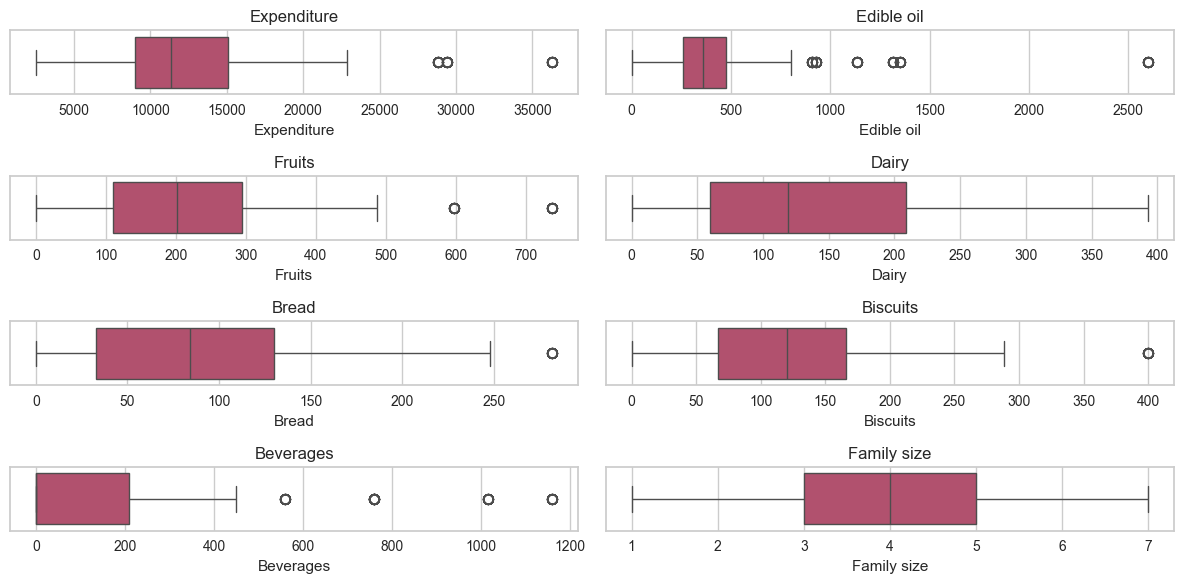

In [30]:
# Select numeric columns from the DataFrame
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns

# Set the number of rows and columns for subplots
num_rows = len(numeric_columns) // 2 + (len(numeric_columns) % 2 > 0)  # Round up to the nearest integer
num_cols = 2  # Two columns for each row

# Creating subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6))

# Flatten the axes if necessary
if num_rows == 1 and num_cols == 1:
    axes = [axes]

# Plot each numeric column
for i, column in enumerate(numeric_columns):
    row = i // num_cols
    col = i % num_cols
    sns.boxplot(x=df[column], ax=axes[row][col],palette="flare")
    axes[row][col].set_title(column)

# Adjust layout
plt.tight_layout()
#plt.savefig("first.PNG")
plt.show()

**From the graph we can see there are some outlier in the data we will try to adjust it now.**

In [31]:
# Filtering out rows where 'expenditure', 'Beverages', and 'Edible oil' exceed the specified thresholds
df = df[(df['Expenditure'] < 25000) & 
        (df['Beverages'] < 800) & 
        (df['Edible oil'] < 800)]

print('After removing the outliers:', len(df))


After removing the outliers: 1200


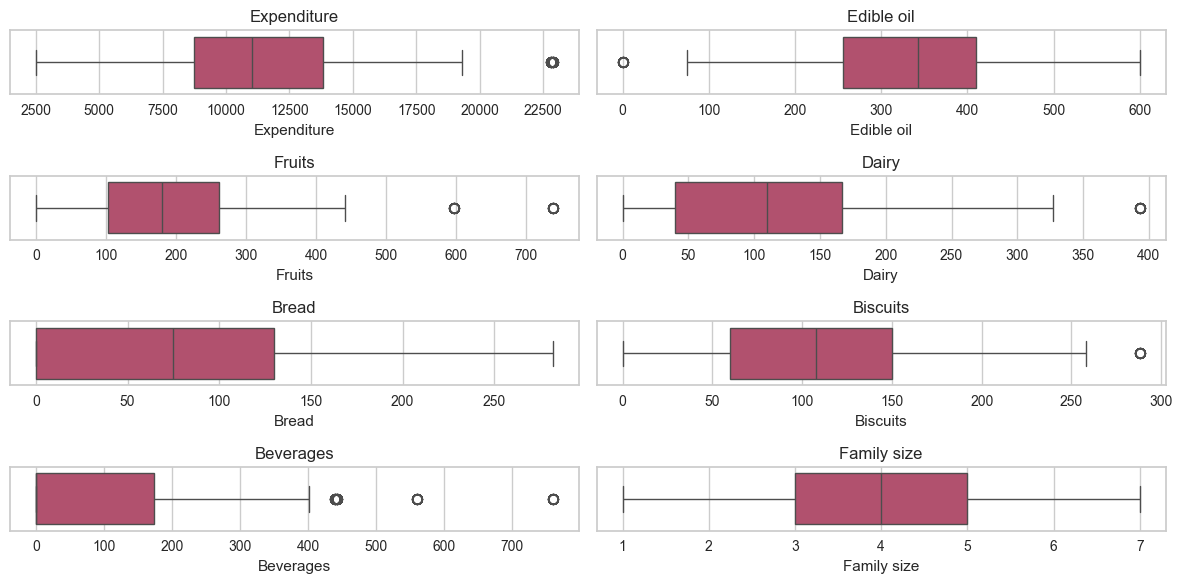

In [32]:
# Select numeric columns from the DataFrame
numeric_columns = df.select_dtypes(include=['int64', 'float64']).columns

# Set the number of rows and columns for subplots
num_rows = len(numeric_columns) // 2 + (len(numeric_columns) % 2 > 0)  # Round up to the nearest integer
num_cols = 2  # Two columns for each row

# Create subplots
fig, axes = plt.subplots(num_rows, num_cols, figsize=(12, 6))

# Flatten the axes if necessary
if num_rows == 1 and num_cols == 1:
    axes = [axes]

# Plot each numeric column
for i, column in enumerate(numeric_columns):
    row = i // num_cols
    col = i % num_cols
    sns.boxplot(x=df[column], ax=axes[row][col],palette="flare")
    axes[row][col].set_title(column)

# Adjust layout
plt.tight_layout()
#plt.savefig("second.PNG")
plt.show()

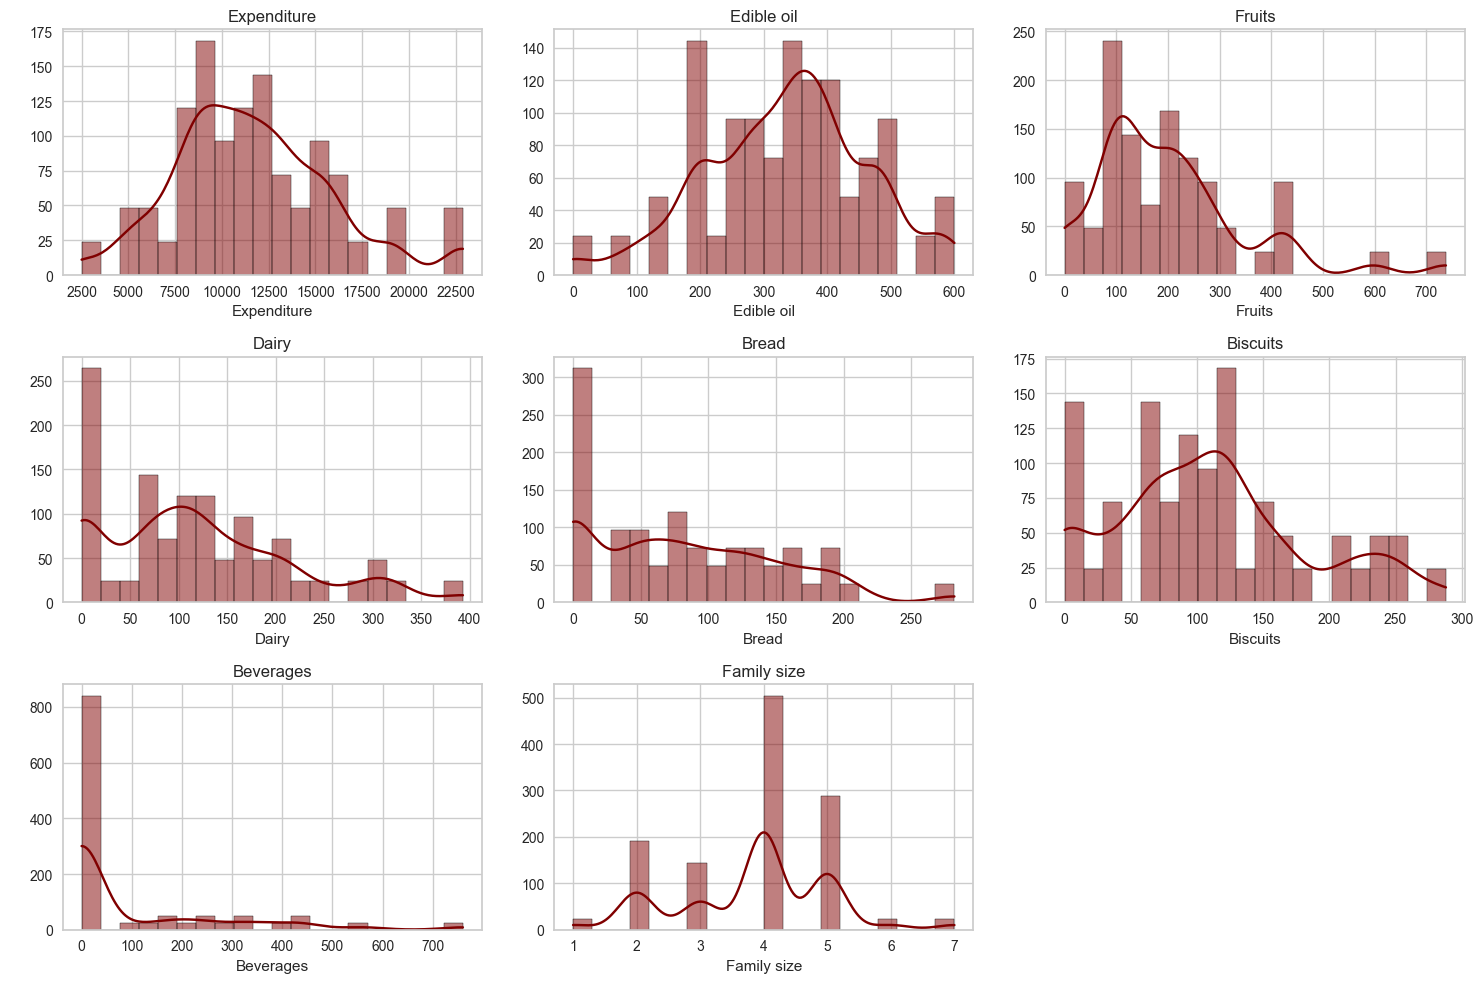

In [33]:
# let's look at the distribution
# Filter numeric columns
numeric_columns = df.select_dtypes(include=['int64', 'float64'])

# Set figure size
plt.figure(figsize=(15, 10))

# Loop through each numeric column and create distribution plot
for i, column in enumerate(numeric_columns.columns, 1):
    plt.subplot(3, 3, i)
    sns.histplot(df[column], kde=True, color='maroon', bins=20)
    plt.title(column)
    plt.ylabel(" ")

# Adjust layout
plt.tight_layout()
plt.savefig("third.PNG")
plt.show()

### Visualisation 

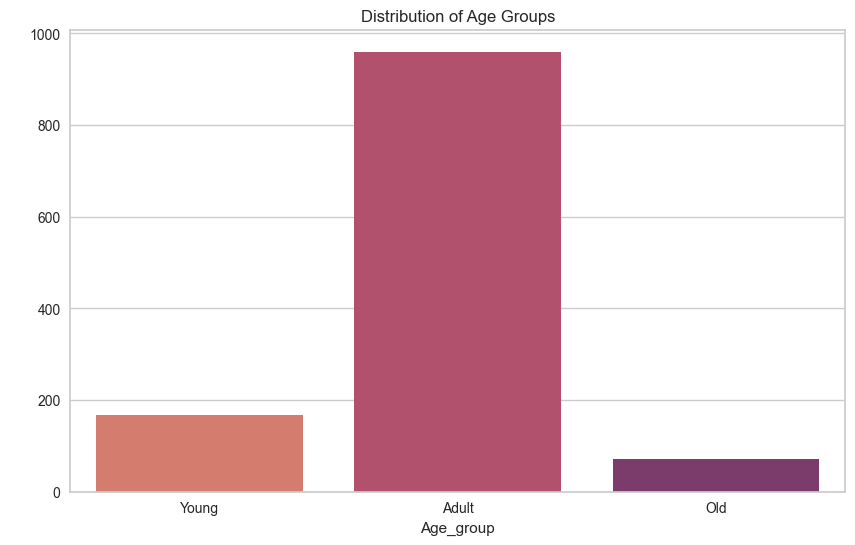

In [35]:
# let's look at the age distribution
plt.figure(figsize=(10, 6))
sns.countplot(x='Age_group', data=df,palette = "flare")
plt.title('Distribution of Age Groups')
plt.ylabel(" ")
plt.show()

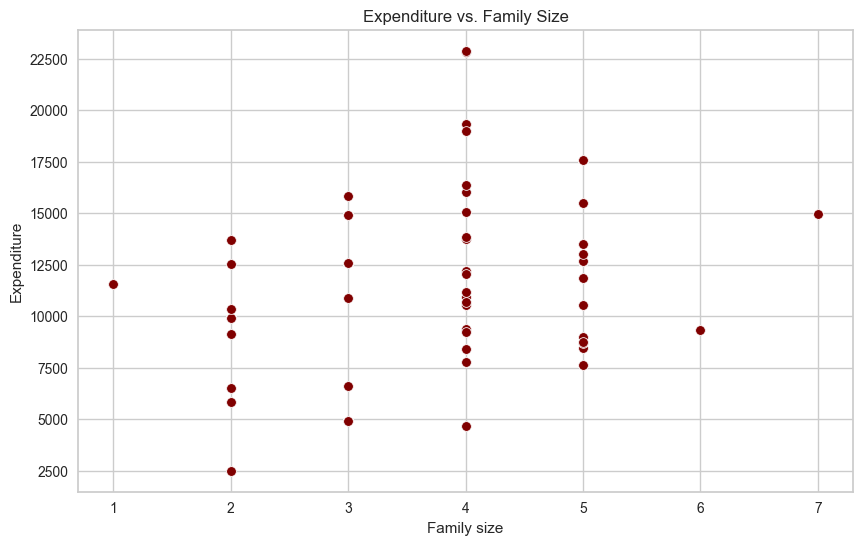

In [36]:
# Scatter plot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='Family size', y='Expenditure', data=df,color="maroon")
plt.title('Expenditure vs. Family Size')
plt.savefig("fifth.PNG")
plt.show()

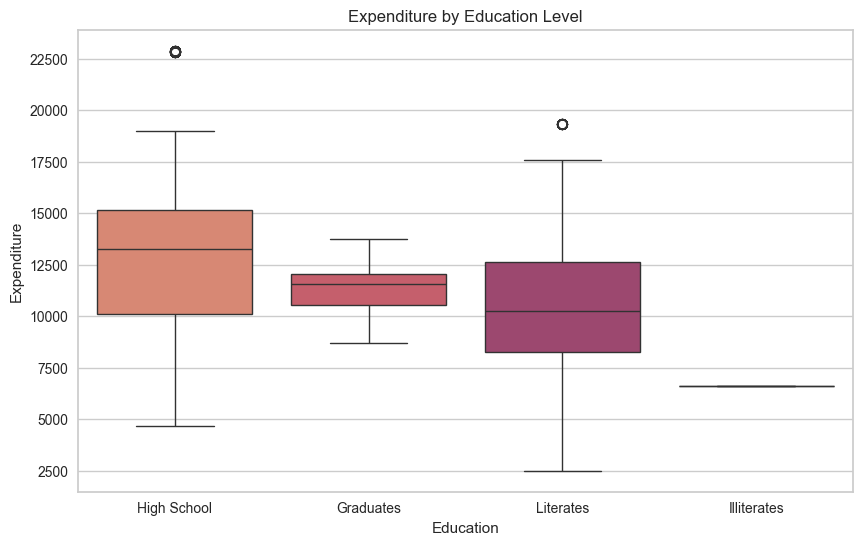

In [37]:
# Box plot
plt.figure(figsize=(10, 6))
sns.boxplot(x='Education', y='Expenditure', data=df,palette="flare")
plt.title('Expenditure by Education Level')
plt.savefig("6.PNG")
plt.show()

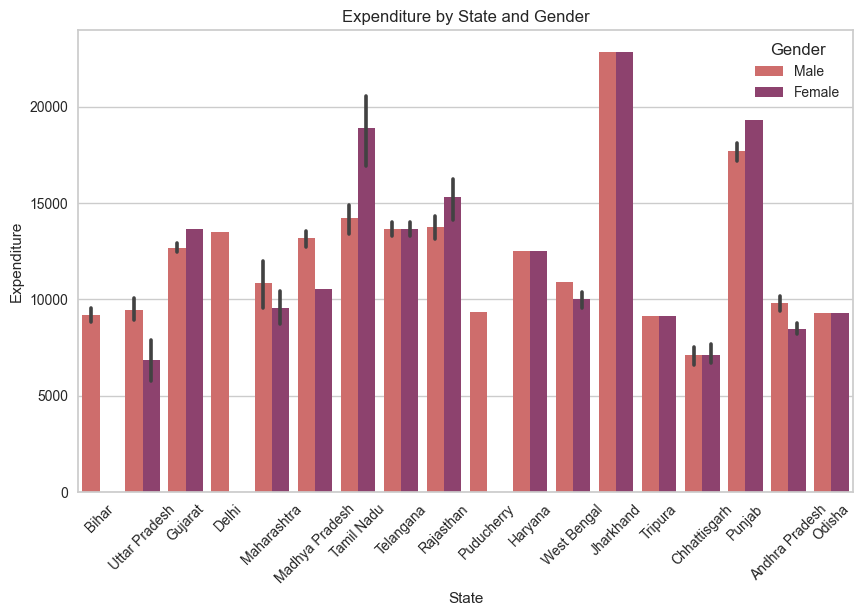

In [44]:
# Graph to show expenditure based on state and gender
plt.figure(figsize=(10, 6))
sns.barplot(x='State', y='Expenditure', hue='Gender', data=df,palette="flare")
plt.title('Expenditure by State and Gender')
plt.xticks(rotation=45)
plt.savefig("7.PNG")
plt.show()

<Figure size 800x550 with 0 Axes>

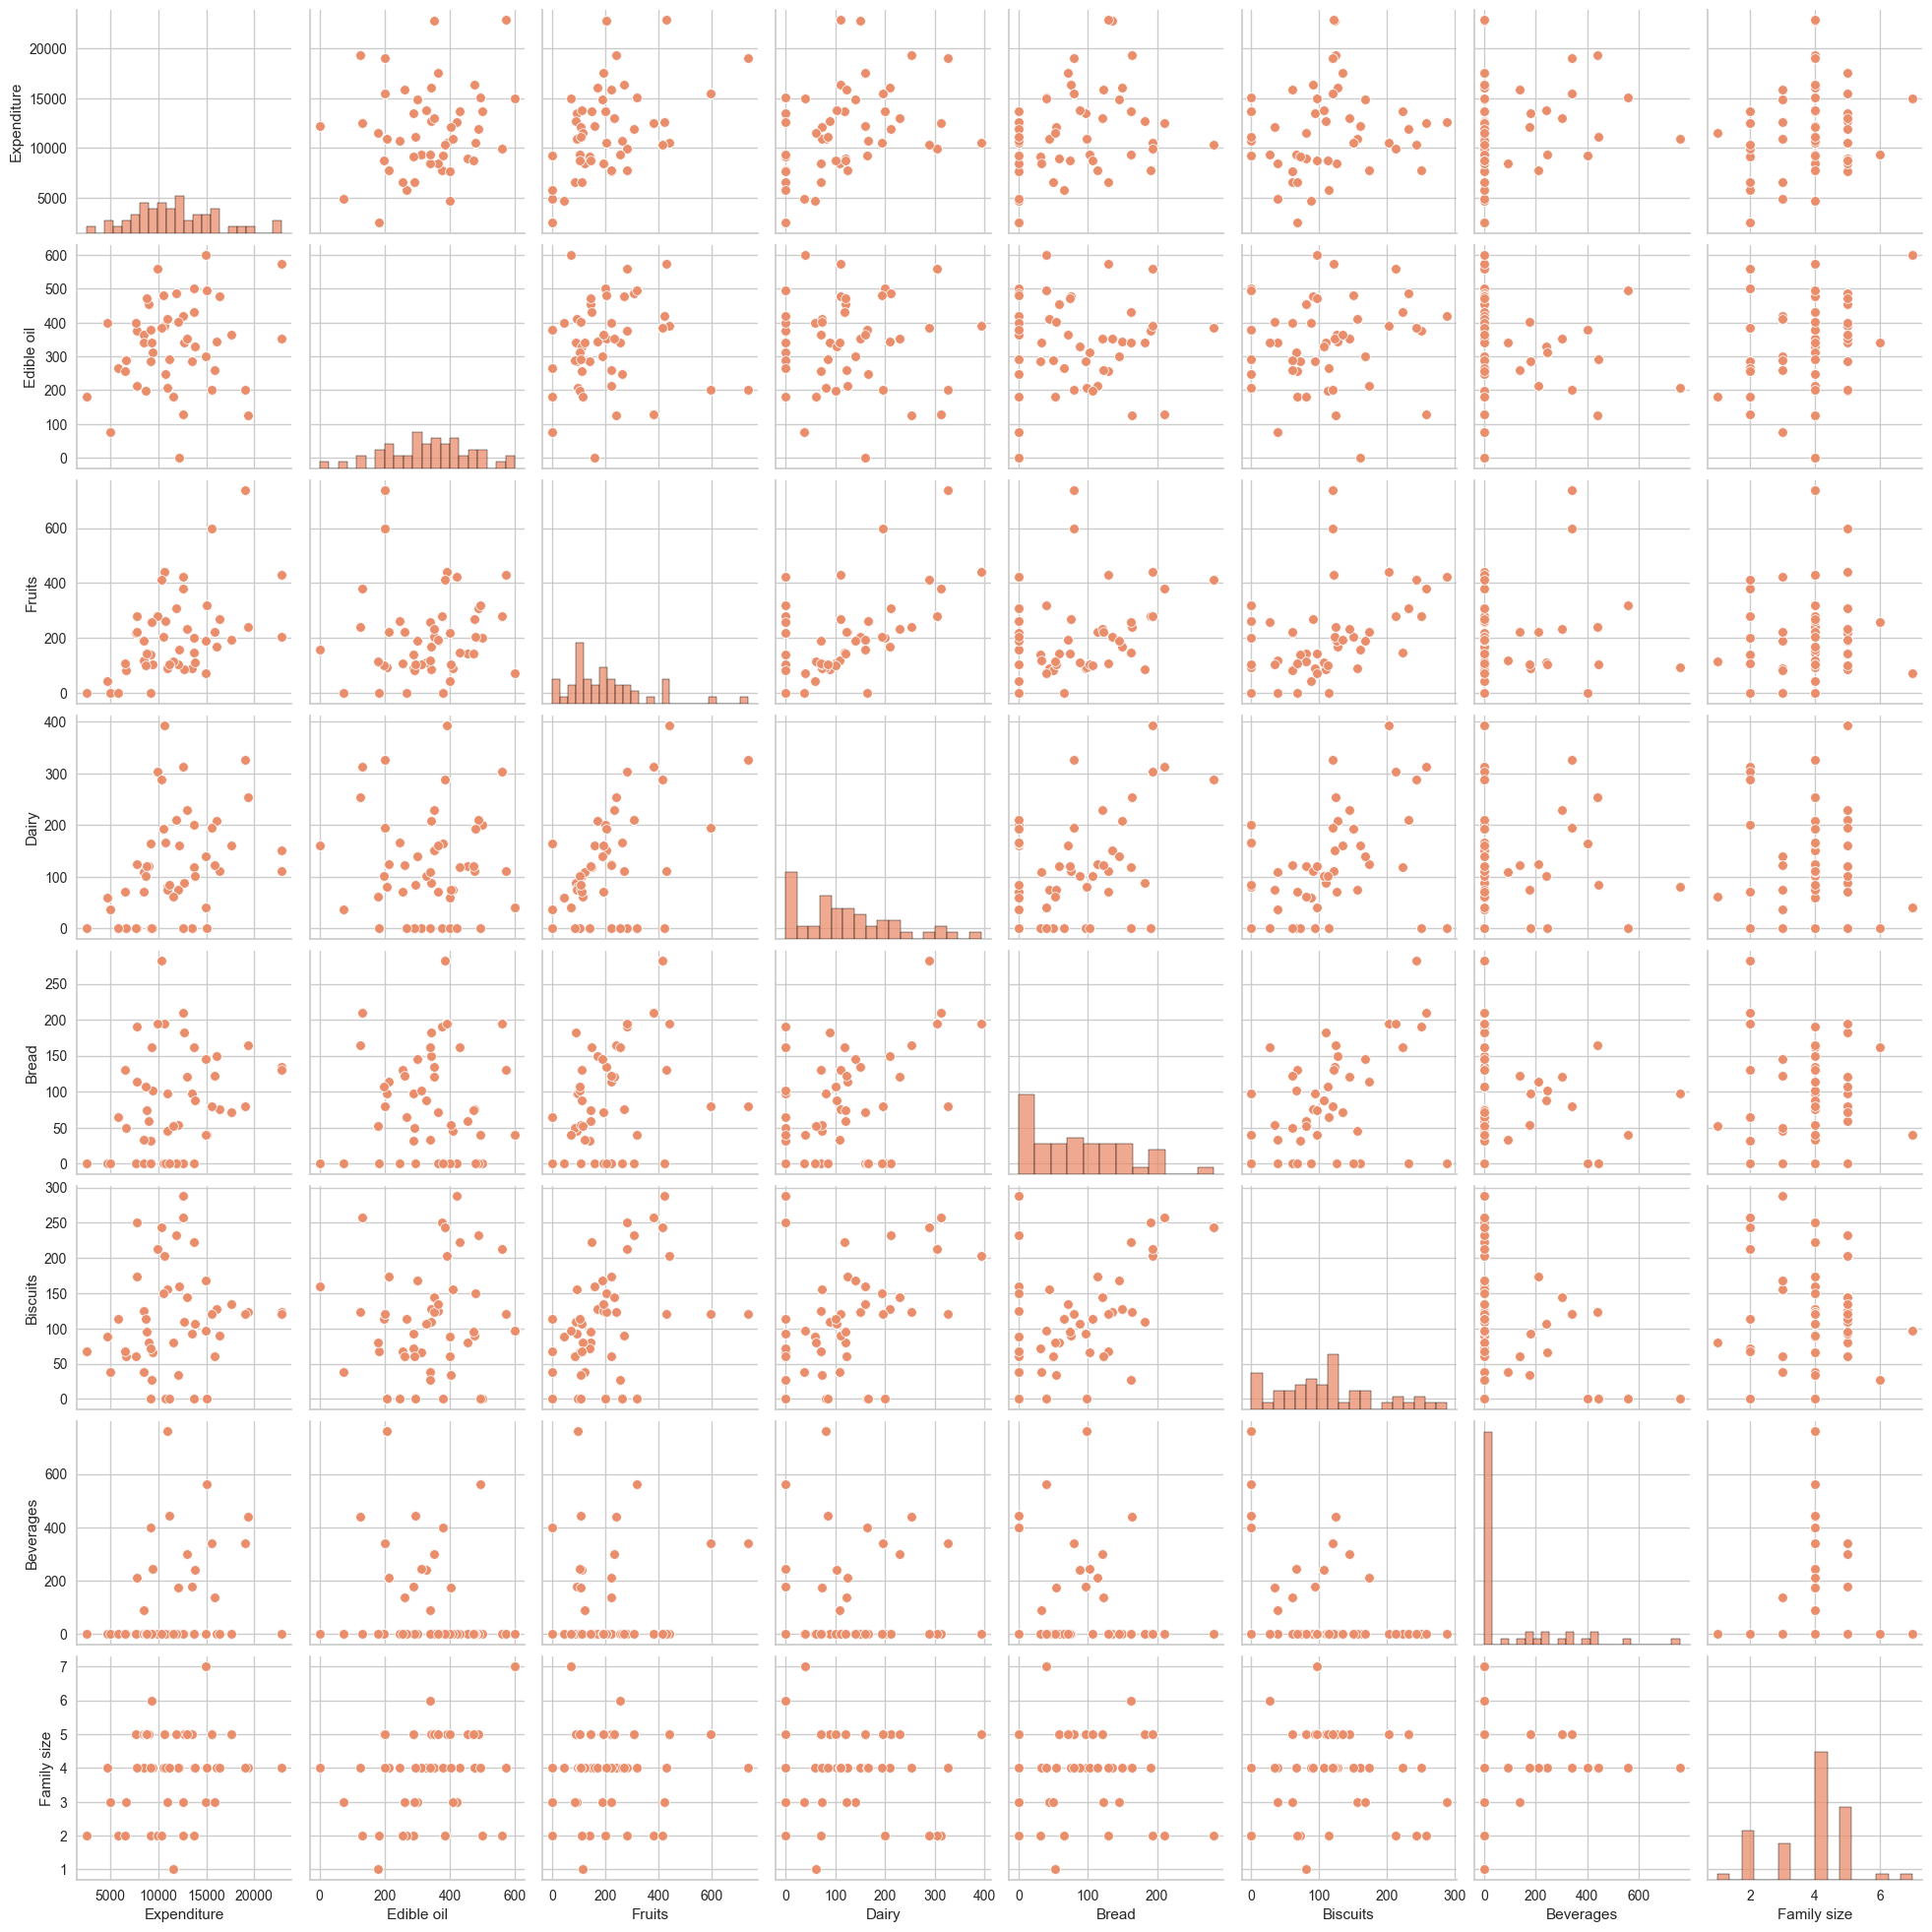

In [45]:
# let's look at the relationship between different features

plt.suptitle("Pair Plot")

# Set the custom color palette
sns.set_palette("flare")

# Create pairplot
sns.pairplot(df[['Expenditure', 'Edible oil', 'Fruits', 'Dairy', 'Bread', 'Biscuits', 'Beverages', 'Family size']])


# Show the plot
plt.show()


### Correlations

In [46]:
numeric_data = df.select_dtypes(include=['float64', 'int64'])

# Compute correlation matrix
corrmat = numeric_data.corr()
corrmat

,Expenditure,Edible oil,Fruits,Dairy,Bread,Biscuits,Beverages,Family size
Expenditure,1.000000,0.175375,0.491532,0.374008,0.270498,0.131779,0.200234,0.206952
Edible oil,0.175375,1.000000,0.079293,-0.009496,-0.004876,0.094912,-0.201602,0.270400
Fruits,0.491532,0.079293,1.000000,0.558459,0.319128,0.426089,0.096053,0.078642
Dairy,0.374008,-0.009496,0.558459,1.000000,0.412738,0.391236,0.041065,-0.025499
Bread,0.270498,-0.004876,0.319128,0.412738,1.000000,0.471205,-0.040938,-0.061500
Biscuits,0.131779,0.094912,0.426089,0.391236,0.471205,1.000000,-0.379059,-0.078774
Beverages,0.200234,-0.201602,0.096053,0.041065,-0.040938,-0.379059,1.000000,0.139971
Family size,0.206952,0.270400,0.078642,-0.025499,-0.061500,-0.078774,0.139971,1.000000


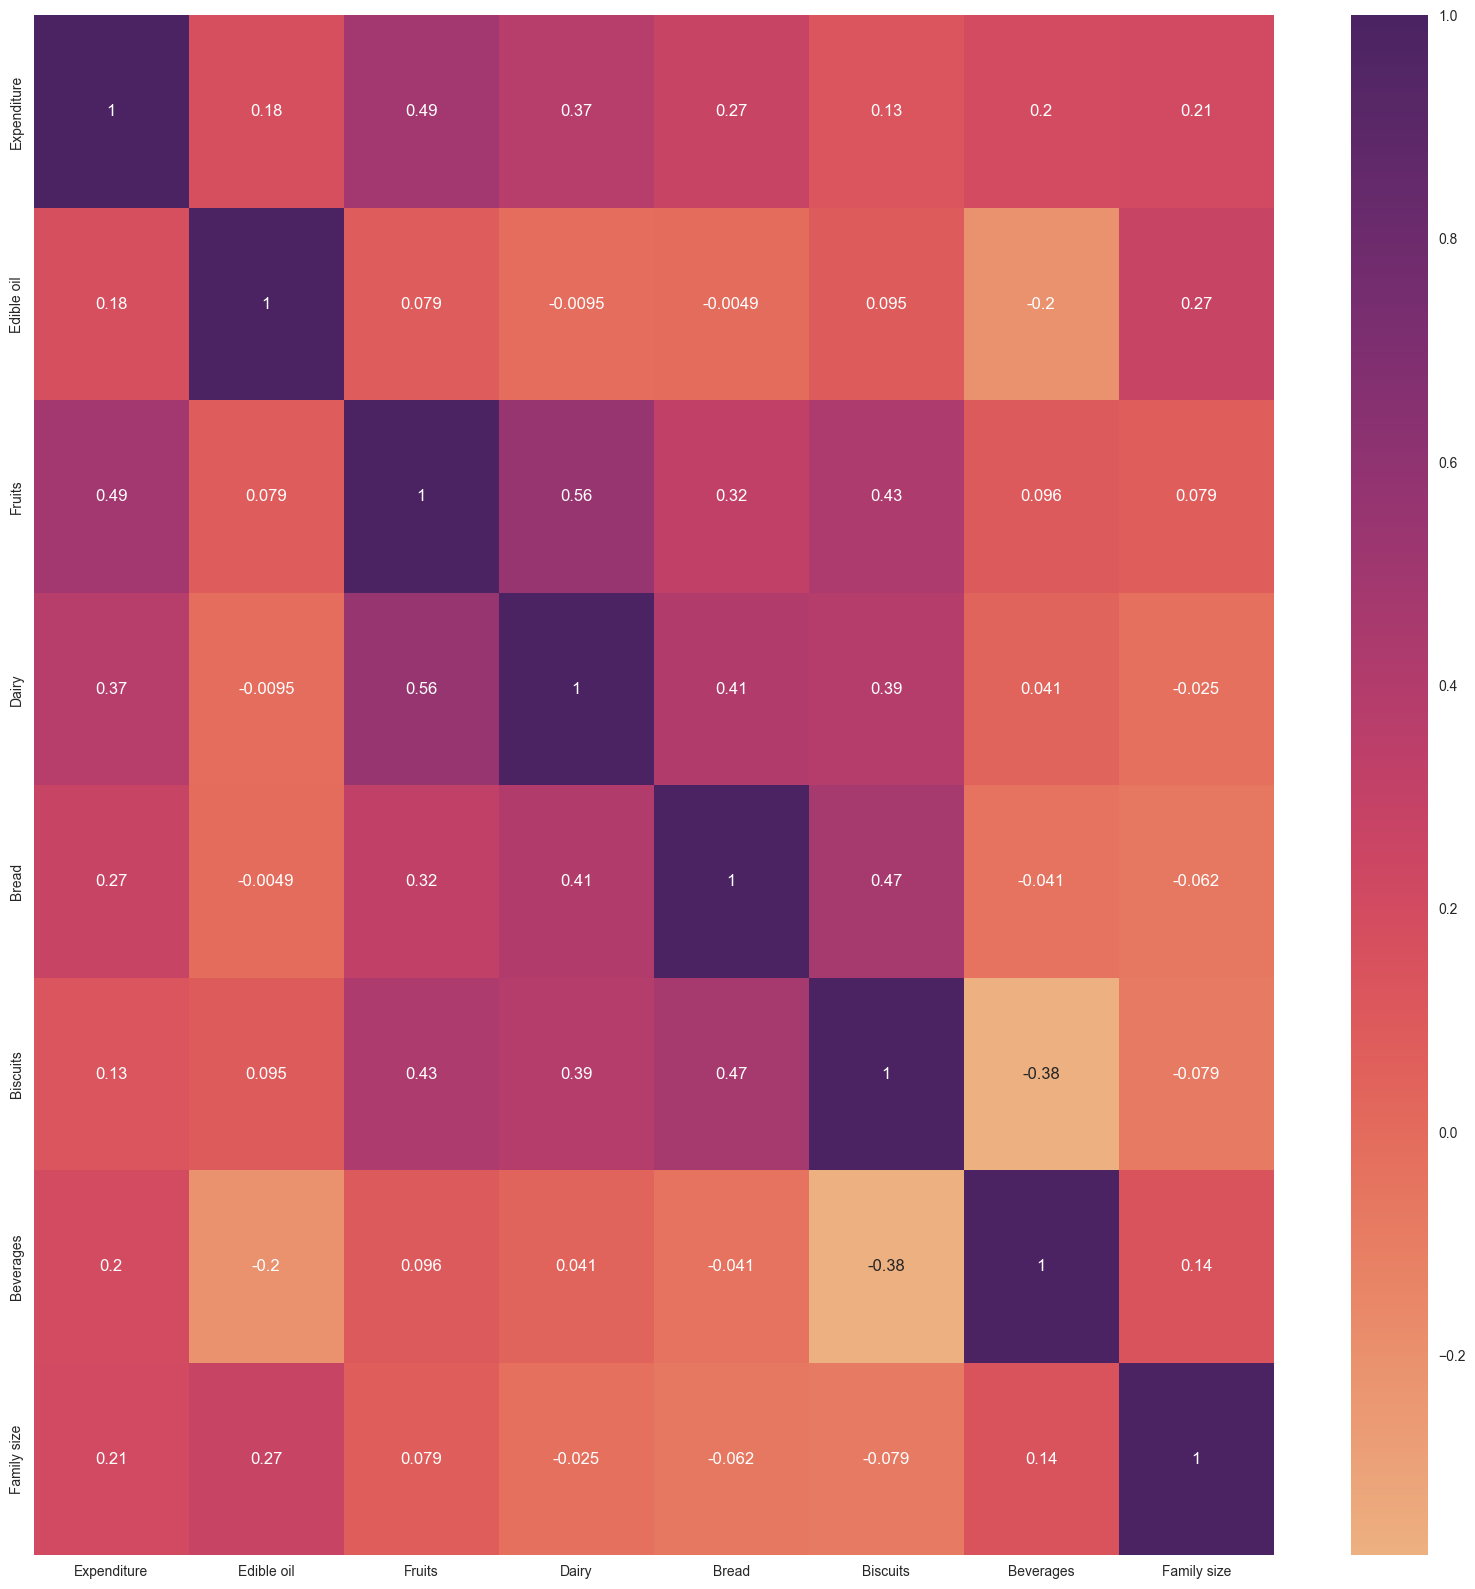

In [47]:
# Plot heatmap
plt.figure(figsize=(20,20))
sns.heatmap(corrmat,cmap = 'flare', annot=True)
plt.savefig("9.PNG")
plt.show()

## Data Pre-processing

In this section, we will preprocessing the data to perform clustering.

**The following steps are applied to preprocess the data:**

* Label encoding the categorical features
* Scaling the features using the standard scaler 
* Creating a subset dataframe for dimensionality reduction


In [48]:
#list of categorical variables
s = (df.dtypes == 'object')
object_cols = list(s[s].index)

print("Categorical variables in the dataset:", object_cols)

Categorical variables in the dataset: ['Age_group', 'State', 'Occupation', 'Education', 'Gender', 'Region_type']


In [49]:
#Label Encoding the object dtypes.
encoder=LabelEncoder()
for i in object_cols:
    df[i]=df[[i]].apply(encoder.fit_transform)
    
print("All features are now numerical")

All features are now numerical


In [50]:
#Scaling
scaler = StandardScaler()
scaler.fit(df)
scaled_df = pd.DataFrame(scaler.transform(df),columns= df.columns )
print("All features are now scaled")

All features are now scaled


In [51]:
print("Dataframe to be used for further modelling:")

scaled_df.head()

Dataframe to be used for further modelling:


,Age_group,State,Occupation,Education,Gender,Region_type,Expenditure,Edible oil,Fruits,Dairy,Bread,Biscuits,Beverages,Family size
0,2.337333,-1.494914,-1.383046,-0.782230,0.685994,1.0,-0.627929,0.946758,-0.388456,0.012435,-0.337368,-0.413345,-0.553412,0.975376
1,-0.478731,1.143169,-0.380839,-1.671128,0.685994,1.0,0.482138,0.758098,-0.361291,-0.007950,1.133797,1.540004,-0.553412,0.134535
2,-0.478731,-0.967297,1.623576,0.995565,0.685994,1.0,0.118664,-2.629918,-0.279797,0.420140,-1.180074,0.679438,-0.553412,0.134535
3,-0.478731,1.143169,0.621369,0.995565,0.685994,1.0,-0.905797,0.325753,0.535146,-1.210679,1.533725,1.908818,-0.553412,0.134535
4,-0.478731,-1.143169,-1.383046,-0.782230,0.685994,-1.0,0.431382,-0.373861,-0.741598,-1.210679,0.205392,-0.235768,0.471847,0.975376


## DIMENSIONALITY REDUCTION

In the dataframe, there are many factors on the basis of which the final classification can be done. These factors are the attributes or features. The higher the number of attributes, the harder it is to work with it. Many of these features are correlated, and hence not very useful. That's why we will perform dimensionality reduction on the selected features before putting them through a classifier. 

##### Dimensionality reduction is the process of reducing the number of random variables under consideration, by obtaining a set of principal variables.

**Principal component analysis (PCA)** is a technique for reducing the dimensionality of such datasets, increasing interpretability but at the same time minimizing information loss.

**Steps in this section:**
* Dimensionality reduction with PCA
* Plotting the reduced dataframe

### Dimensionality reduction with PCA

In [52]:
pca = PCA()

pca.fit(scaled_df)

PCA()

PCA essentially creates as many components as there are features in our data, in our case seven. Moreover, these components are arranged in order of importance. Importance here indicates how much of the variance of our data is explained by each components. To do this, we can use the explained variance ratio attribute to actually check what happened.

In [53]:
pca.explained_variance_ratio_

array([0.21908833, 0.12182396, 0.10784722, 0.09573647, 0.08218197,
       0.06742504, 0.06407691, 0.04859843, 0.04340802, 0.03896912,
       0.03458163, 0.03074208, 0.02651079, 0.01901004])

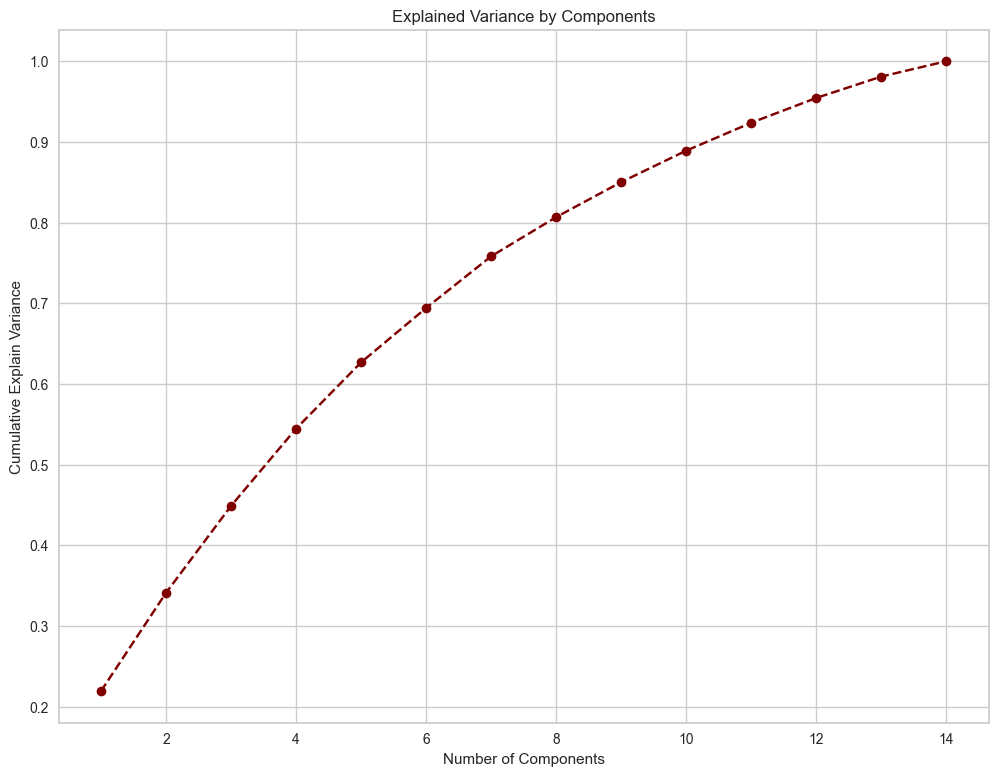

In [54]:
#we will plot this to decide how many feature to keep.
plt.figure(figsize=(12,9))

plt.plot(range(1,15), pca.explained_variance_ratio_.cumsum(), marker = 'o', linestyle = '--',color="maroon")
plt.title('Explained Variance by Components')
plt.xlabel('Number of Components')
plt.ylabel('Cumulative Explain Variance')

plt.show()

This graph will help us decide how many components to keep in our dimensionality reduction. If we choose two components, we can see that we preserve around 50% of the information, if we choose three components, around 55% and so on.

#### How to choose the number of components?

A rule of thumb is to keep at least 70 to 80 percent of the explained variance.
So we will take 7 components

In [55]:
# taking number of components to be 7
pca = PCA(n_components = 7)

pca.fit(scaled_df)

PCA(n_components=7)

### PCA Result

In [56]:
print(pca.components_)

[[-1.03237413e-01  1.47795853e-01  9.68125533e-02 -1.91775587e-01
  -1.45537883e-02  3.94478910e-01  3.74838599e-01  8.43329450e-02
   4.52949144e-01  4.28660666e-01  3.36540648e-01  3.38180382e-01
   1.71973451e-02  3.27446351e-02]
 [-7.47864111e-02  3.36093231e-01  1.21946294e-01  2.92792625e-01
  -1.18793468e-01 -1.24648347e-01 -2.97286212e-01 -1.06284604e-01
  -3.55979986e-02 -1.95892500e-02  1.87935662e-01  4.12518837e-01
  -4.77577433e-01 -4.65083370e-01]
 [ 5.34760108e-01 -2.81831563e-01 -5.81029531e-02  4.77085042e-02
   1.40016451e-01 -8.72127465e-02 -2.93171504e-02  4.73919540e-01
  -3.12107855e-02  2.47185618e-02  1.06172966e-01  2.46788878e-01
  -4.36533930e-01  3.34598573e-01]
 [ 1.49154580e-01 -4.66352886e-01 -4.75445248e-01  2.88788872e-01
   1.77302119e-01 -4.92592331e-02 -2.72363095e-02 -4.46260694e-01
   4.03120970e-02  3.02190653e-01  2.44366754e-01  8.75865278e-02
   1.35985762e-01 -1.95562955e-01]
 [ 3.47007575e-01 -8.64189955e-02 -1.10748296e-01  1.19810706e-01
  

The result is a 7x14 array. We reduced our features to 7 components from the original 14, that explains the shape. Thsee values are called loadings. Loadings are correlations between an original variable and a component.

We want to get a better idea of the relationship between components and original features. So we will put this information in pandas dataframe where the data comes from PCA components, while the columns from the original column values of the dataframe.

In [57]:
df_pca_comp = pd.DataFrame(data = pca.components_,
                           columns = df.columns.values,
                           index = ['Comp 1', 'Comp 2', 'Comp 3','Comp 4','Comp 5','Comp 6','Comp 7'])
df_pca_comp

,Age_group,State,Occupation,Education,Gender,Region_type,Expenditure,Edible oil,Fruits,Dairy,Bread,Biscuits,Beverages,Family size
Comp 1,-0.103237,0.147796,0.096813,-0.191776,-0.014554,0.394479,0.374839,0.084333,0.452949,0.428661,0.336541,0.338180,0.017197,0.032745
Comp 2,-0.074786,0.336093,0.121946,0.292793,-0.118793,-0.124648,-0.297286,-0.106285,-0.035598,-0.019589,0.187936,0.412519,-0.477577,-0.465083
Comp 3,0.534760,-0.281832,-0.058103,0.047709,0.140016,-0.087213,-0.029317,0.473920,-0.031211,0.024719,0.106173,0.246789,-0.436534,0.334599
Comp 4,0.149155,-0.466353,-0.475445,0.288789,0.177302,-0.049259,-0.027236,-0.446261,0.040312,0.302191,0.244367,0.087587,0.135986,-0.195563
Comp 5,0.347008,-0.086419,-0.110748,0.119811,-0.800480,0.315749,0.097337,0.083640,-0.042830,0.024934,-0.046787,-0.194672,-0.008121,-0.214367
Comp 6,0.293791,-0.248053,0.686669,-0.202208,0.061720,0.243771,-0.324482,-0.342376,-0.142988,0.118176,0.123990,-0.034267,0.055246,-0.000249
Comp 7,-0.027013,-0.070562,-0.352378,-0.703917,0.142472,0.216924,-0.132804,0.024924,-0.156668,0.062897,-0.163743,-0.037033,-0.308860,-0.370042


**Let's look at the Heatmap**

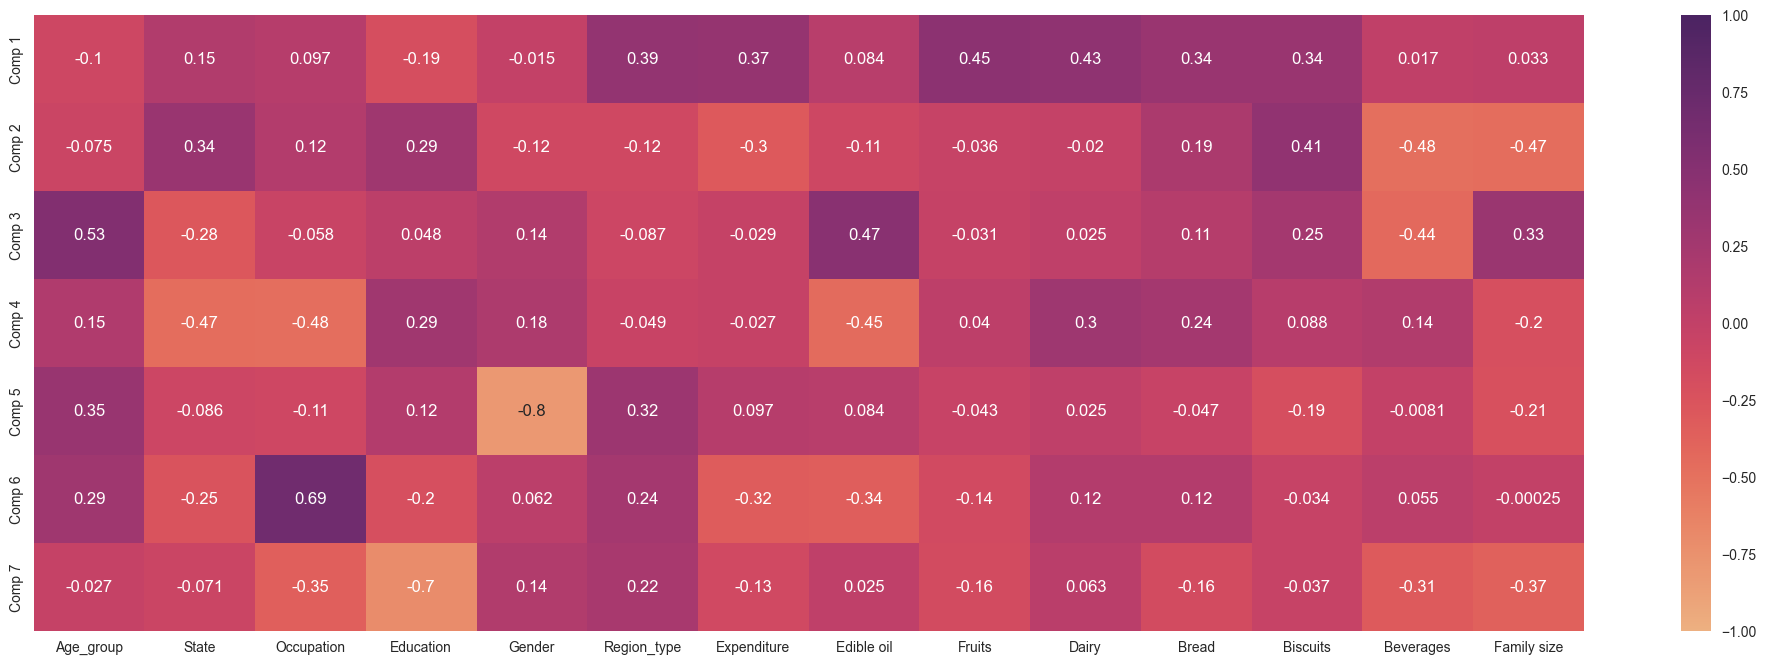

In [58]:
plt.figure(figsize = (25,8))

sns.heatmap(df_pca_comp,
            vmin = -1,
            vmax = 1,
            cmap = 'flare',
            annot = True)
plt.savefig("12.PNG")

### Conclusion

Comp 1:

Positive Loadings: "Region_type," "Expenditure," "Edible oil," "Fruits," "Dairy," "Bread," "Biscuits."
Interpretation: This component seems to represent spending patterns related to different regions, with higher expenditure on various food items like edible oil, fruits, dairy, bread, and biscuits.
Comp 2:

Positive Loadings: "Gender," "Beverages," "Family size."
Negative Loadings: "State," "Occupation," "Education," "Bread," "Biscuits."
Interpretation: Comp 2 appears to capture demographic differences in beverage consumption and family size, with variations based on state, occupation, and educational background.
Comp 3:

Positive Loadings: "Expenditure," "Edible oil," "Dairy," "Bread," "Beverages."
Negative Loadings: "State," "Occupation," "Fruits," "Biscuits."
Interpretation: This component might reflect spending patterns related to essential food items and beverages, influenced by factors such as state, occupation, and dietary preferences.
Comp 4:

Positive Loadings: "Occupation," "Expenditure," "Edible oil," "Dairy."
Negative Loadings: "Gender," "Bread," "Biscuits," "Beverages."
Interpretation: Comp 4 seems to capture spending patterns influenced by occupation and dietary choices, with differences across gender groups.
Comp 5:

Positive Loadings: "Gender," "Region_type," "Bread," "Biscuits," "Beverages."
Negative Loadings: "Age_group," "Expenditure," "Edible oil," "Fruits."
Interpretation: This component might represent variations in spending habits across different demographic groups and food items.
Comp 6:

Positive Loadings: "Age_group," "Region_type," "Expenditure," "Edible oil," "Fruits," "Beverages."
Negative Loadings: "Occupation," "Bread," "Biscuits."
Interpretation: Comp 6 seems to capture spending patterns influenced by age group, region type, and dietary preferences, with less expenditure on certain food items among specific occupational groups.
Comp 7:

Positive Loadings: "Occupation," "Education," "Fruits," "Bread," "Beverages," "Family size."
Negative Loadings: "Gender," "Region_type," "Biscuits."
Interpretation: This component could represent spending patterns related to educational and occupational backgrounds, dietary habits, and family size, with variations across gender and region type.

In [59]:
# transforming the scaled dataframe and assigning it to score_pca
score_pca = pca.transform(scaled_df)
score_pca

array([[-0.61868266, -1.60467578,  2.63274574, ...,  0.69300617,
         0.43023093,  1.44415874],
       [ 1.8613431 ,  0.5173372 ,  0.5163064 , ..., -0.90790762,
        -0.36977517,  1.44688931],
       [-0.03921468,  0.50024661, -0.92313785, ..., -0.66379124,
         2.05031972, -0.59889821],
       ...,
       [-0.77709667, -1.90718016,  2.03143874, ..., -1.27895383,
        -1.36829514, -0.05802926],
       [ 0.8830418 , -0.13746589,  1.55536606, ...,  2.21205795,
         0.42726689, -1.32524631],
       [ 3.76214486, -1.60191038, -1.47959791, ..., -0.56258967,
        -0.42168212, -0.17407648]])

## Clustering algorithm : K-Means CLustering 

K-means clustering is a popular unsupervised machine learning algorithm used for 
partitioning a dataset into a predetermined number of clusters, represented by K. The 
algorithm aims to group data points into clusters in such a way that each data point belongs to 
the cluster with the nearest mean (centroid).

### K-Means Clustering after PCA

wcss or within-cluster sum of squares is the sum of the squared distance between each data point and the centroid(mean) of the cluster to which the data point belongs. It measures the compactness of the clusters formed.

In [60]:
wcss = []
for i in range(1,11):
    kmeans_pca = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans_pca.fit(score_pca)
    wcss.append(kmeans_pca.inertia_)

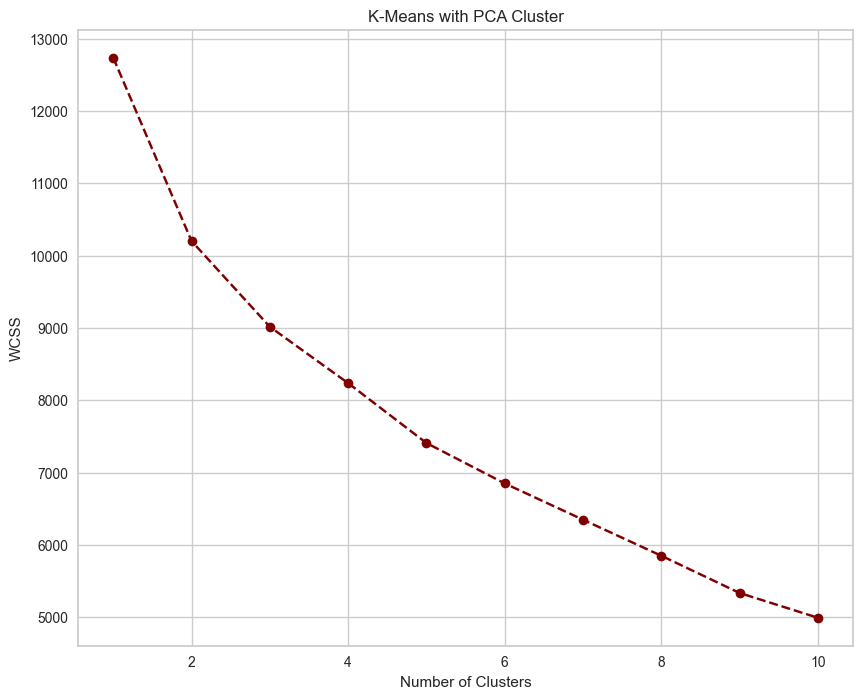

In [61]:
plt.figure(figsize = (10,8))
plt.plot(range(1,11), wcss, marker = 'o', linestyle = '--',color="maroon")
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.title('K-Means with PCA Cluster')
plt.savefig("13.PNG")

we see the fuction is monotonically decreasing. Sometimes it can be rapidly declining, other times more smoothly, depending on the shape of this graph, we make a decision about the number of clusters. To do this, we will use an aaproach known as the elbow method. As we can see, this graph looks like an arm with an elbow. The goal here is to spot the elbow itself and take that many clusters. Usually the part of the graph below would be steeply declining while the part after it much smoother. It is very clear from the graph, the elbow on the graph is at the fourth cluster mark. This is the only place until which the graph is steeply declining while smoothening out afterwards.

In [62]:
# taking 4 as number of clusters
kmeans_pca = KMeans(n_clusters = 4, init = 'k-means++', random_state = 42)
kmeans_pca.fit(score_pca)

KMeans(n_clusters=4, random_state=42)

### K-Means clustering with PCA results

We will create a new dataframe and add the values of the separate components to our copy dataframe (df), the values are in the score_pca variable. And label them as component 1, 2, 3 and so on. Next we append the Kmeans PCA labels to the new dataframe.

In [63]:
df_pca_kmeans = pd.concat([df.reset_index(drop=True), pd.DataFrame(score_pca)],axis = 1)
df_pca_kmeans.columns.values[-7: ] = ['Component 1' , 'Component 2', 'Component 3', 'Component 4', 'Component 5', 'Component 6', 'Component 7']
df_pca_kmeans['Segment K-means PCA'] = kmeans_pca.labels_

In [66]:
df_pca_kmeans

,Age_group,State,Occupation,Education,Gender,Region_type,Expenditure,Edible oil,Fruits,Dairy,Bread,Biscuits,Beverages,Family size,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Component 7,Segment K-means PCA
0,2,1,0,1,1,1,8983,455,144,120,59,80,0,5,-0.618683,-1.604676,2.632746,0.747865,0.693006,0.430231,1.444159,2
1,0,16,1,0,1,1,13729,431,148,118,162,223,0,4,1.861343,0.517337,0.516306,-0.891719,-0.907908,-0.369775,1.446889,1
2,0,4,3,3,1,1,12175,0,160,160,0,160,0,4,-0.039215,0.500247,-0.923138,0.923305,-0.663791,2.050320,-0.598898,3
3,0,16,2,3,1,1,7795,376,280,0,190,250,0,4,1.040046,2.097859,0.496865,-0.564646,-1.029552,0.144203,-0.905083,1
4,0,3,0,1,1,0,13512,287,92,0,97,93,180,5,-1.203142,-1.478966,0.179875,0.726563,-1.037093,-0.839672,0.454250,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,2,1,1,3,1,0,8742,472,144,120,74,96,0,5,-1.515397,-0.579660,2.975425,0.896693,0.116633,0.263001,-0.626624,2
1196,0,11,0,1,1,1,15520,200,597,195,80,120,340,5,2.376217,-1.812071,-1.119462,1.100071,-0.703835,-0.867281,0.041735,1
1197,0,7,1,1,1,0,14943,600,71,40,40,97,0,7,-0.777097,-1.907180,2.031439,-1.730122,-1.278954,-1.368295,-0.058029,2
1198,2,12,2,3,0,1,17595,363,193,160,72,134,0,5,0.883042,-0.137466,1.555366,-0.459537,2.212058,0.427267,-1.325246,1


In [69]:
# calculating mean values of each feature by clusters.
df_pca_kmeans_freq = df_pca_kmeans.groupby(['Segment K-means PCA']).mean()
df_pca_kmeans_freq

,Age_group,State,Occupation,Education,Gender,Region_type,Expenditure,Edible oil,Fruits,Dairy,Bread,Biscuits,Beverages,Family size,Component 1,Component 2,Component 3,Component 4,Component 5,Component 6,Component 7
Segment K-means PCA,,,,,,,,,,,,,,,,,,,,,
0,0.285714,12.857143,1.142857,2.000000,0.571429,0.142857,6456.571429,235.000000,58.428571,32.714286,40.000000,75.285714,0.000000,2.285714,-1.983520,1.380951,-0.863502,-0.081031,0.164021,0.066893,0.791959
1,0.181818,10.454545,1.181818,1.666667,0.575758,0.939394,14529.939394,344.303030,316.969697,205.121212,139.454545,162.181818,80.606061,3.636364,1.911436,0.227752,-0.012880,0.371626,0.285101,-0.185378,0.134909
2,1.200000,3.100000,0.800000,2.100000,0.800000,0.200000,10380.700000,391.700000,119.600000,87.000000,65.600000,77.800000,97.100000,4.800000,-1.295723,-0.974289,1.462207,0.544919,0.158481,0.035562,-0.104370
3,0.000000,11.000000,2.030303,1.909091,0.757576,0.393939,11796.121212,332.424242,195.454545,88.212121,54.181818,92.848485,154.969697,4.121212,-0.284656,-0.223132,-0.506971,-0.667503,-0.450735,0.135446,-0.407637


Segment 0:
This segment has a relatively moderate expenditure compared to other segments.
They have a medium family size.
Their spending pattern suggests a balanced consumption across different food items, with a slightly higher focus on edible oil and biscuits compared to other segments.
In terms of demographics, they might represent a mix of different age groups, occupations, education levels, and genders.
Component analysis suggests they are characterized by relatively lower scores on Component 1 and Component 4, and higher scores on Component 7.
Segment 1:
This segment has the highest expenditure among the identified segments, indicating higher purchasing power or different spending habits.
They have a slightly larger family size compared to Segment 0.
Their spending pattern shows a preference for fruits and beverages, suggesting a potentially healthier lifestyle or higher interest in these items.
Demographically, they might be slightly older, with diverse occupations and higher education levels.
Component analysis suggests they have higher scores on Component 1 and Component 6 compared to other segments.
Segment 2:
This segment has a lower expenditure compared to Segment 1 but higher than Segment 0.
They have the largest family size among the segments, indicating potentially larger households.
Their spending pattern indicates a preference for dairy products, with relatively lower expenditure on fruits and beverages.
Demographically, they might represent a slightly younger population with moderate education levels and diverse occupations.
Component analysis suggests they have higher scores on Component 2 and Component 3 compared to other segments.
Segment 3:
This segment has a moderate expenditure similar to Segment 0.
They have a smaller family size compared to Segment 2.
Their spending pattern shows a significant preference for edible oil and dairy products, with lower expenditure on other food items.
Demographically, they might be similar to Segment 0 but with potentially different occupation distributions.
Component analysis suggests they have higher scores on Component 5 compared to other segments.

### Cluster Profilling

1. Segment 0: Balanced Consumers 
Expenditure: Moderate 
Family Size: Medium 
Spending Pattern: Balanced consumption, higher focus on edible oil and biscuits 
Demographics: Diverse age groups, occupations, education levels, and genders 
Component Scores: Lower on Components 1 and 4, higher on Component 7
2. Segment 1: Affluent Health Enthusiasts  
Expenditure: Highest 
Family Size: Slightly larger than Segment 0 
Spending Pattern: Preference for fruits and beverages
Demographics: Slightly older, diverse occupations, higher education levels 
Component Scores: Higher on Components 1 and 6
3. Segment 2: Young Large Families 
Expenditure: Lower than Segment 1 but higher than Segment 0
Family Size: Largest 
Spending Pattern: Preference for dairy products, lower on fruits and beverages 
Demographics: Slightly younger, moderate education levels, diverse occupations 
Component Scores: Higher on Components 2 and 3
4. Segment 3: Selective Spenders 
Expenditure: Moderate, similar to Segment 0 
Family Size: Smaller than Segment 2 
Spending Pattern: Significant preference for edible oil and dairy products 
Demographics: Similar to Segment 0, different occupation distributions 
Component Scores: Higher on Component 5

In [70]:
df_pca_kmeans['Legend'] = df_pca_kmeans['Segment K-means PCA'].map({0:'Balanced Consumers',
                                                1:'Affluent Health Enthusiats',
                                                2:'Young Large Families',
                                                3:'Selective Spenders'})

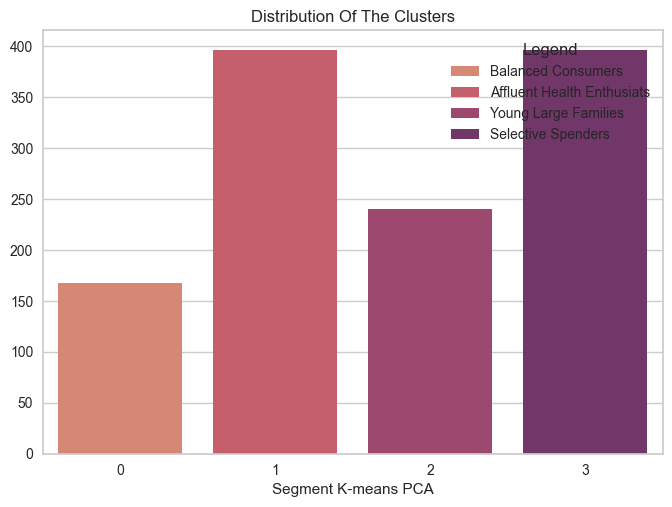

In [71]:
#Plotting countplot of clusters
pl = sns.countplot(data = df_pca_kmeans,x="Segment K-means PCA",hue="Legend", palette= "flare")
pl.set_title("Distribution Of The Clusters")
plt.ylabel("")
plt.savefig("14.PNG")
plt.show()

**we can see that that segment 1 and segment 3 are almost same in size.**

### Let's look at the expenditure on various items

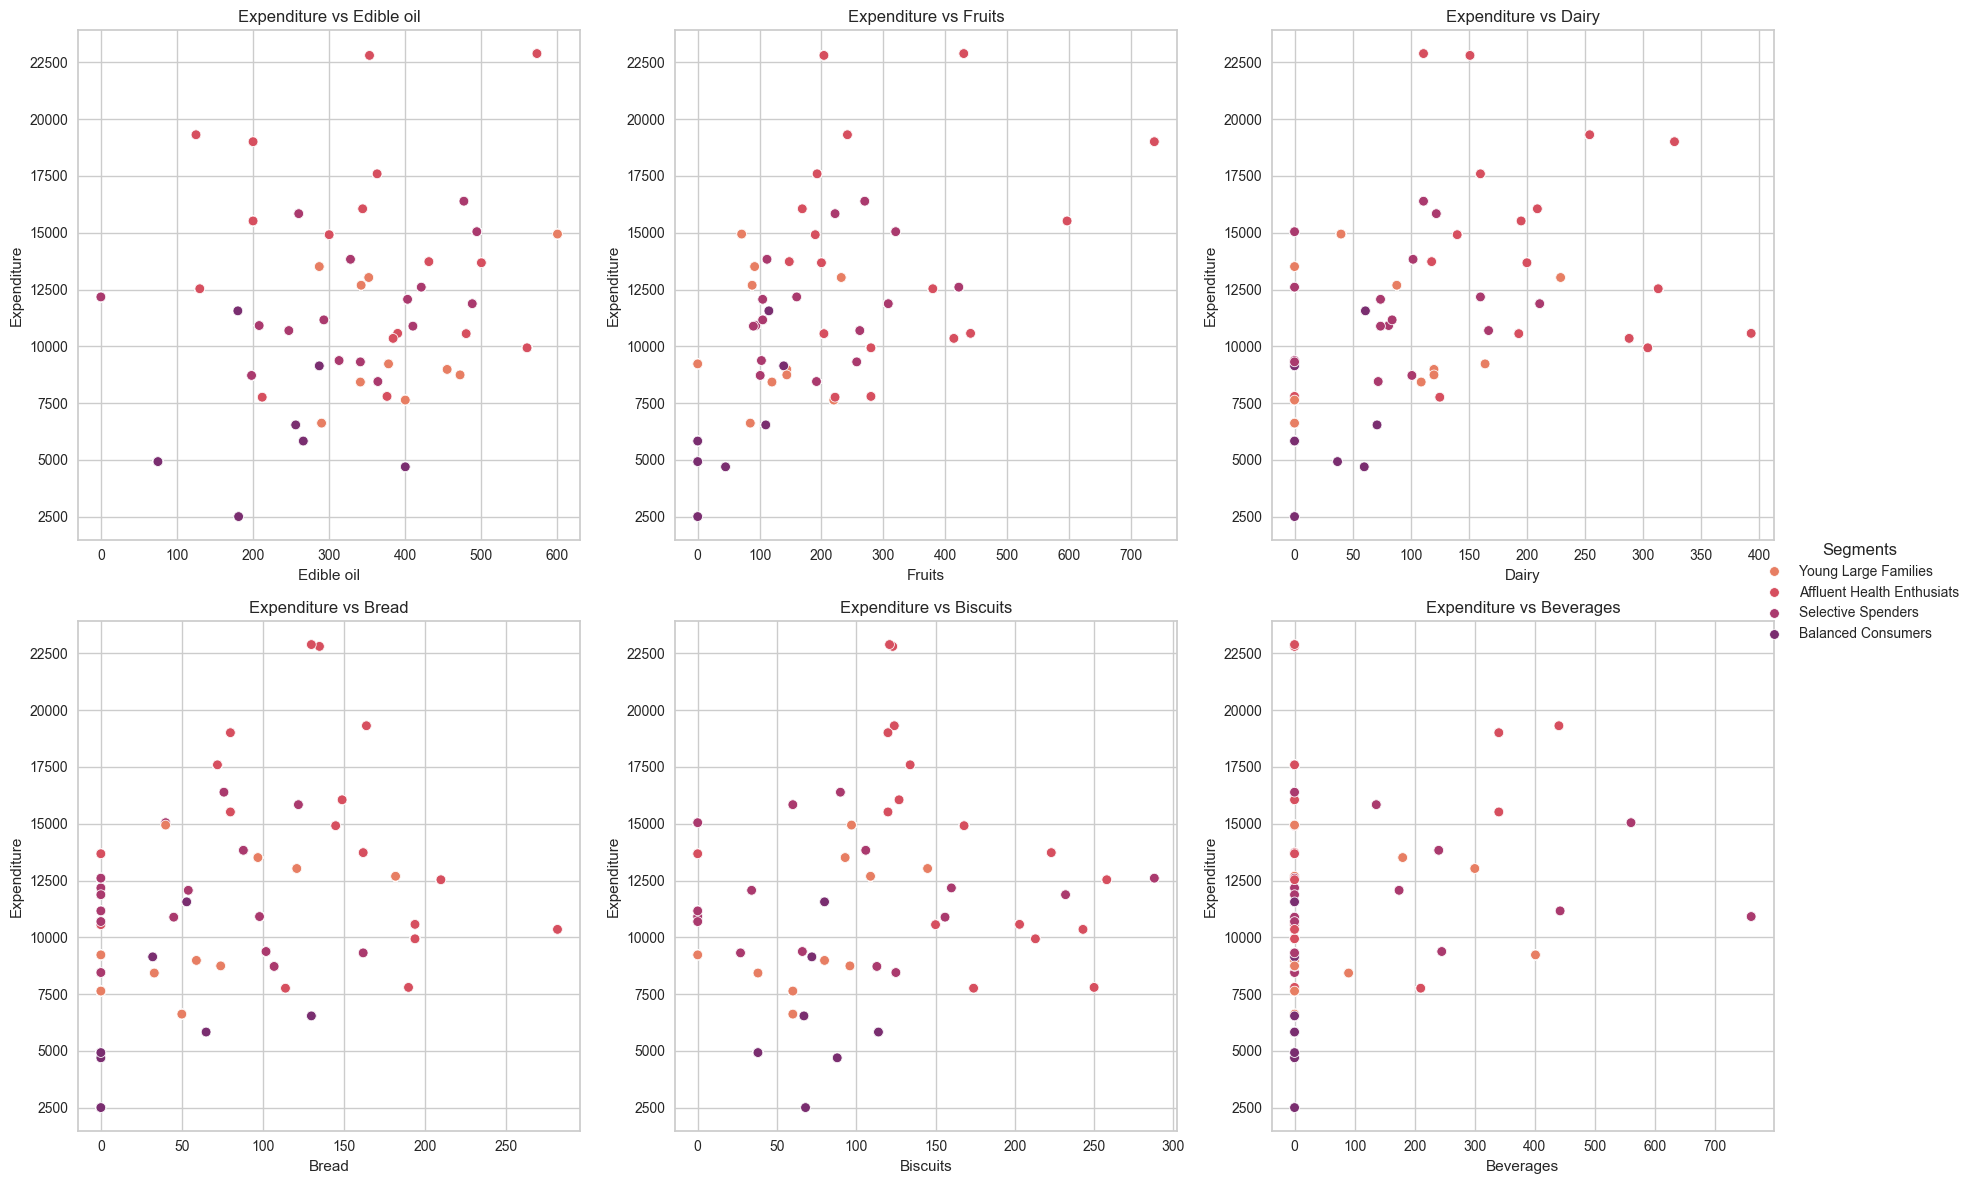

In [74]:
# Create a grid of subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# Flatten the axes array for easier iteration
axes = axes.flatten()

product_categories = ['Edible oil', 'Fruits', 'Dairy', 'Bread', 'Biscuits', 'Beverages']

# Iterate over each product category and plot the corresponding scatter plot
for i, category in enumerate(product_categories):
    # Plot the scatter plot
    sns.scatterplot(data=df_pca_kmeans, x=category, y='Expenditure', hue='Legend', palette='flare', ax=axes[i])
    axes[i].set_title(f'Expenditure vs {category}')
    axes[i].set_xlabel(category)
    axes[i].set_ylabel('Expenditure')
    
    # Remove legend from each subplot
    axes[i].get_legend().remove()

# Adjust layout to prevent overlap
plt.tight_layout()

# Create a single legend for all subplots
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title='Segments', loc='center right', bbox_to_anchor=(1.1, 0.5))


# Show the plot
plt.show()


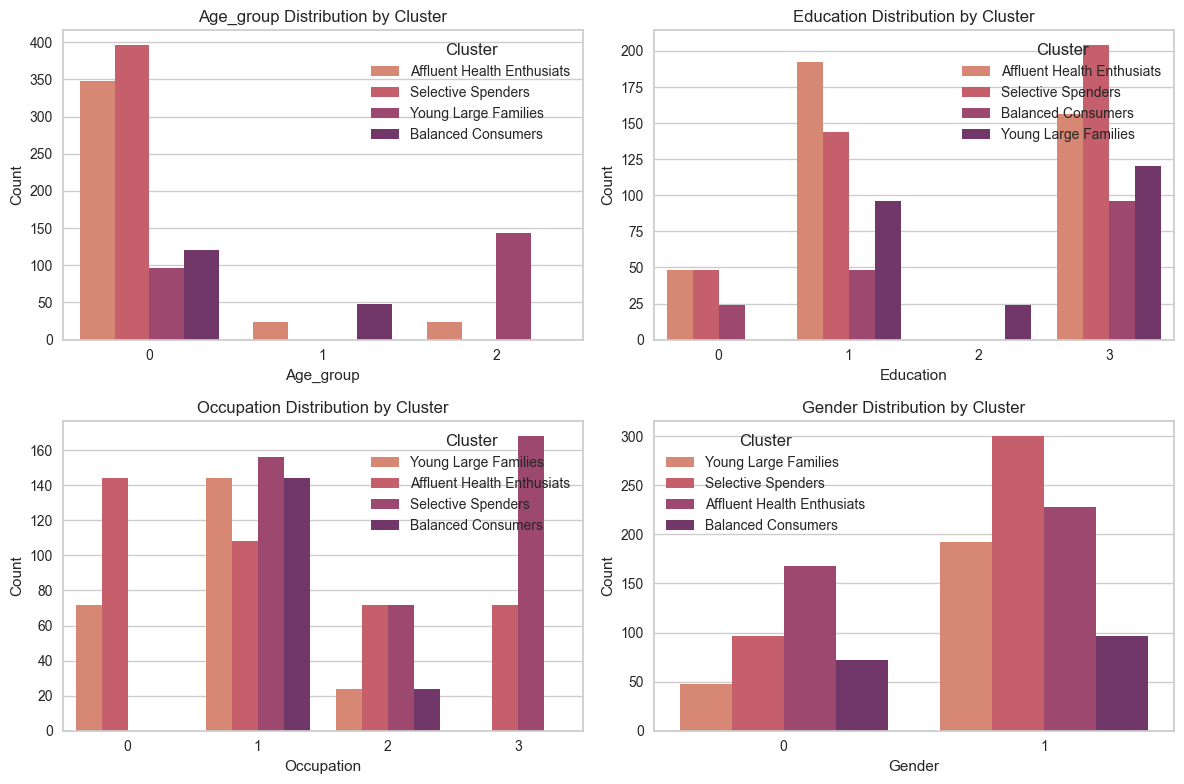

In [75]:
# Demographic Distributions
plt.figure(figsize=(12, 8))
for i, feature in enumerate(['Age_group', 'Education', 'Occupation', 'Gender']):
    plt.subplot(2, 2, i+1)
    sns.countplot(x=feature, data=df_pca_kmeans,hue='Legend', palette='flare')
    plt.title(f'{feature} Distribution by Cluster')
    plt.xlabel(feature)
    plt.ylabel('Count')
    plt.legend(title='Cluster')
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, title='Segments', loc='center right', bbox_to_anchor=(1.1, 0.5))
plt.tight_layout()
plt.savefig("17.PNG")
plt.show()


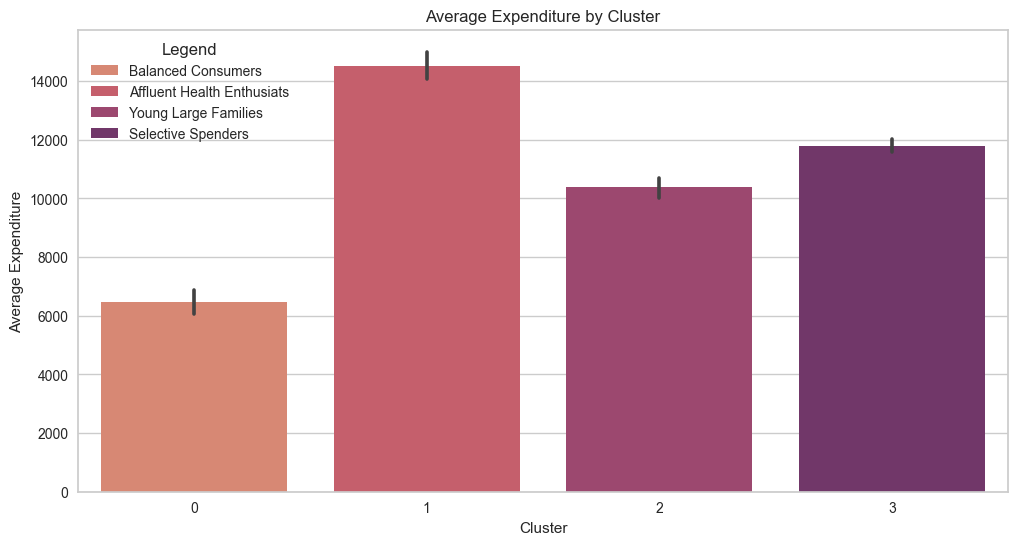

In [76]:
# Expenditure Patterns
plt.figure(figsize=(12, 6))
sns.barplot(x='Segment K-means PCA', y='Expenditure', hue='Legend', data=df_pca_kmeans, estimator=np.mean,palette = 'flare')
plt.title('Average Expenditure by Cluster')
plt.xlabel('Cluster')
plt.ylabel('Average Expenditure')
plt.xticks(rotation=0)
plt.savefig("18.PNG")
plt.show()


**The most senpending segment is segment 1**

### Conclusion

**This study aimed to segment the FMCG customers using K-means clustering and PCA, based on demographic characteristics, purchasing patterns.**

The analysis identified four distinct customer segments: Balanced Consumers, Affluent Health Enthusiasts, Young Large Families, and Selective Spenders.

1. **Balanced Consumers:** Moderate expenditure and balanced consumption across various food items.

2. **Affluent Health Enthusiasts:** High expenditure with a preference for fruits and beverages.

3. **Young Large Families:** Prioritize dairy consumption, reflecting larger household sizes.

4. **Selective Spenders:** Moderate expenditure with a preference for edible oil and dairy products.